# Modelos de Regresión y Clasificación
Dentro de este Jupyter Notebook, aplicamos diferentes modelos de regresion y clasificacion para intentar realizar predicciones sobre el dataset de Olist y evaluar su rendimiento. Entre las variables y los modelos incluimos

- Modelos de Regresion
    - Prediccion de Review Score, a pesar de ser mas un problema de clasificacion decidimos incluirlo dentro de regresiones para tener un analisis comparativo
    - Prediccion de Delivery Days

- Modelos de Clasificacion
    - Prediccion de Review Score
    - Prediccion de Delivery Delayed, para pedidos atrasados
    - Prediccion de Satisfaccion del Cliente, 4+ en Review Score = Satisfecho. No satisfecho de lo contrario

Antes de empezar a trabajar con los modelos, vamos a separar todos nuestros splits de train / test. Esto lo haremos separando un DF por cada una de nuestras variable objetivo, para prevenir scaling poco adecuado o data leakage a traves de variables como 'delivery delayed' para 'delivery time'.

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Primero, separamos en predicciones de review_score, delivery_days y delivery_delayed
dfreview = pd.read_csv('dataset/cleaned_orders.csv')
dfreview = dfreview.dropna()

dfdays = pd.read_csv('dataset/cleaned_orders.csv')
dfdays = dfdays.dropna()

dfdelayed = pd.read_csv('dataset/cleaned_orders.csv')
dfdelayed = dfdelayed.dropna()

# Dropeamos columnas que pueden causar data leakage
dfdays.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dfdelayed.drop(columns=['delivery_days', 'delivery_delta', 'review_score'], inplace=True)

# Separar en test y train con 30/70 para predicciones de satisfaccion
review_train, review_test = train_test_split(
    dfreview,
    test_size=0.3,
    stratify=dfreview['review_score'],
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery_days
days_train, days_test = train_test_split(
    dfdays,
    test_size=0.3,
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery_delayed
delayed_train, delayed_test = train_test_split(
    dfdelayed,
    test_size=0.3,
    random_state=42
)

Y_review_train = review_train['review_score']
X_review_train = review_train.drop(columns=['review_score'])

Y_review_test = review_test['review_score']
X_review_test = review_test.drop(columns=['review_score'])

Y_days_train = days_train['delivery_days']
X_days_train = days_train.drop(columns=['delivery_days'])

Y_days_test = days_test['delivery_days']
X_days_test = days_test.drop(columns=['delivery_days'])

Y_delayed_train = delayed_train['delivery_delayed']
X_delayed_train = delayed_train.drop(columns=['delivery_delayed'])

Y_delayed_test = delayed_test['delivery_delayed']
X_delayed_test = delayed_test.drop(columns=['delivery_delayed'])

# Escalamos las columnas correspondientes y separamos en train / test para cada modelo
cols_review = [
    'estimated_delivery_days',
    'delivery_days',
    'delivery_delta',
    'delivery_delayed',
    'avg_product_price',
    'total_order_price',
    'item_count',
    'order_freight_value',
    'freight_to_price',
    'shipping_distance_km',
    'payment_installments',
    'product_size_factor'
]

scaler_review = StandardScaler()

X_review_train[cols_review] = scaler_review.fit_transform(X_review_train[cols_review])
X_review_test[cols_review] = scaler_review.transform(X_review_test[cols_review])

cols_days = [
    'avg_product_price',
    'total_order_price',
    'item_count',
    'order_freight_value',
    'freight_to_price',
    'shipping_distance_km',
    'payment_installments',
    'product_size_factor'
]

scaler_days = StandardScaler()

X_days_train[cols_days] = scaler_days.fit_transform(X_days_train[cols_days])
X_days_test[cols_days] = scaler_days.transform(X_days_test[cols_days])

cols_delayed = [
    'estimated_delivery_days',
    'avg_product_price',
    'total_order_price',
    'item_count',
    'order_freight_value',
    'freight_to_price',
    'shipping_distance_km',
    'payment_installments',
    'product_size_factor'
]

Y_satisfaction_train = (Y_review_train >= 4).astype(int)
Y_satisfaction_test = (Y_review_test >= 4).astype(int)
X_satisfaction_train = X_review_train.copy()
X_satisfaction_test = X_review_test.copy()

scaler_delayed = StandardScaler()
X_delayed_train[cols_delayed] = scaler_delayed.fit_transform(X_delayed_train[cols_delayed])
X_delayed_test[cols_delayed] = scaler_delayed.transform(X_delayed_test[cols_delayed])

Luego, vamos a crear una funcion de utilidad para graficar los resultados de nuestras regresiones.

In [58]:
def plot_regression_results(Y_test, Y_pred, target_column_name="Target", model_name="Model"):
    residuals = Y_test - Y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(Y_test, Y_pred,
                    alpha=0.025,
                    s=10)
    min_val = min(Y_test.min(), Y_pred.min())
    max_val = max(Y_test.max(), Y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val],
             color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel(f"Valores Reales ({target_column_name})", fontsize=12)
    axes[0].set_ylabel(f"Predicciones ({target_column_name})", fontsize=12)
    axes[0].set_title(f"Valores Reales vs Predicciones\n({model_name})", fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].scatter(Y_pred, residuals,
                    alpha=0.025,
                    s=10)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel(f"Valores Predichos ({target_column_name})", fontsize=12)
    axes[1].set_ylabel("Residuos", fontsize=12)
    axes[1].set_title(f"Residuos vs. Predichos\n({model_name})", fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def print_regression_metrics(Y_test, Y_pred, model_name="Model"):
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mse)

    print(f"\n--- Evaluación de {model_name} ---")
    print(f"Mean Squared Error (MSE):     {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE):    {mae:.6f}")
    print(f"R-squared (R²):               {r2:.6f}")
    print("-" * (len(f"--- Evaluación del {model_name} ---")))

Y por ultimo, otras funciones de utilidad para graficar resultados de los modelos de clasificacion

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc # Added confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


def print_classification_metrics(Y_test, Y_pred, model_name="Model", average='weighted'):
    print(f"\n--- Metrics for {model_name} ---")
    print("Accuracy:", accuracy_score(Y_test, Y_pred))
    print("Precision:", precision_score(Y_test, Y_pred, average=average, zero_division=0))
    print("Recall:", recall_score(Y_test, Y_pred, average=average, zero_division=0))
    print("F1-Score:", f1_score(Y_test, Y_pred, average=average, zero_division=0))
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred, zero_division=0))
    print("-" * (len(model_name) + 20)) # Separator line


def plot_confusion_matrix(Y_test, Y_pred, model_name="Model", classes=None):
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes if classes else ['0', '1'],
                yticklabels=classes if classes else ['0', '1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def plot_cap_curve(Y_test, Y_pred_proba, model_name="Model"):
    y_true = Y_test
    y_prob = Y_pred_proba[:, 1]

    df_cap = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df_cap = df_cap.sort_values(by='y_prob', ascending=False)

    n_total = len(y_true)
    n_positive = df_cap['y_true'].sum()

    cumulative_count = np.arange(1, n_total + 1)
    cumulative_positive = df_cap['y_true'].cumsum()

    cap_curve = cumulative_positive / n_positive
    random_curve = cumulative_count / n_total
    perfect_curve = np.minimum(cumulative_count, n_positive) / n_positive

    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_count, cap_curve, label=model_name, color='blue')
    plt.plot(cumulative_count, random_curve, label='Random Model', color='gray', linestyle='--')
    plt.plot(cumulative_count, perfect_curve, label='Perfect Model', color='red', linestyle='--')

    plt.xlabel('Number of Samples')
    plt.ylabel('Cumulative Proportion of Positive Class')
    plt.title(f'Cumulative Accuracy Profile (CAP) Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modelos de Regresion
En esta seccion implementamos los modelos de de regresion Random Forest, KNN y SVR. Para cada uno de estos modelos implementamos predicciones de

- Delivery Days, los dias que se tarda en llegar un pedido
- Review Score, el puntaje de 1-5 dejado en los reviews de un pedido

Es importante tomar en cuenta que el problema de Review Score podría ser resuelto de una manera más adecuada por un modelo de clasificación. Sin embargo, decidimos aplicar modelos de regresión con la finalidad de comparar los modelos y realizar un análisis de regresión vs clasificación para predicciones con valores discretos.

Para cada una de las predicciones implementamos un modelo baseline, luego un modelo con diferentes parametros y por ultimo un modelo con Validacion Cruzada.

## Random Forest

### Delivery Days

**Modelo Baseline**

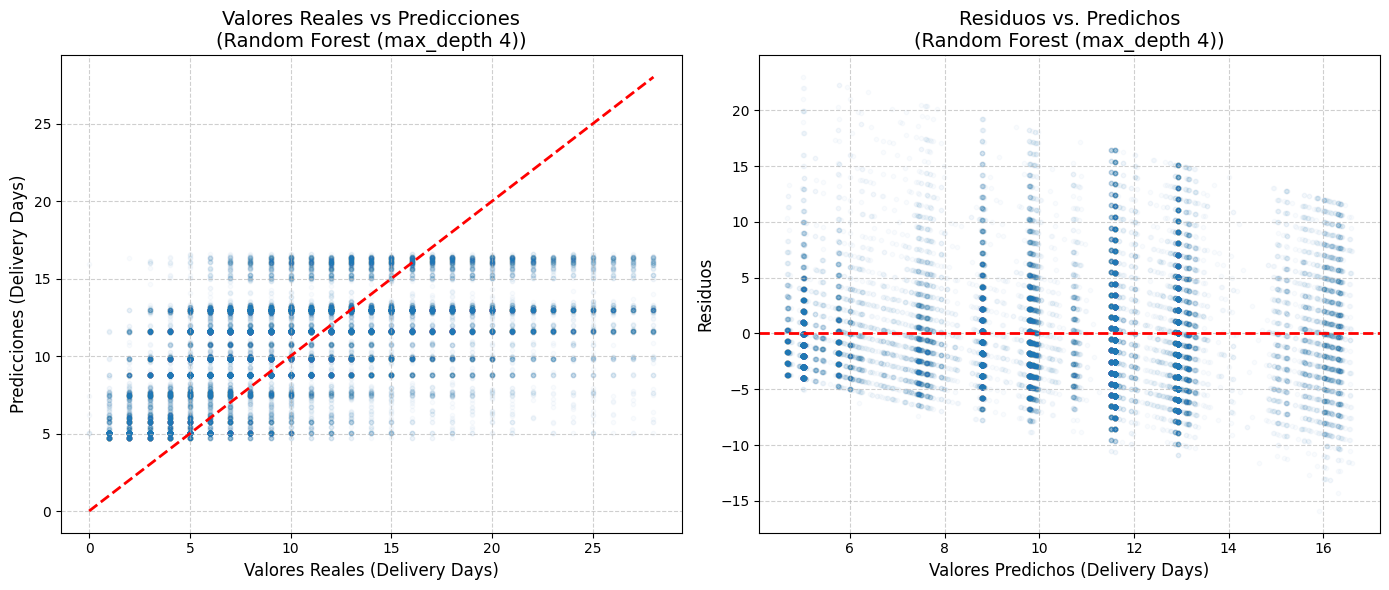


--- Evaluación de Random Forest (max_depth 4) ---
Mean Squared Error (MSE):     25.866034
Root Mean Squared Error (RMSE): 5.085866
Mean Absolute Error (MAE):    3.953223
R-squared (R²):               0.291881
--------------------------------------------------


In [60]:
# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento de modelo
rf_regressor.fit(X_days_train, Y_days_train)

# Predicciones con el modelo
Y_pred = rf_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    target_column_name='Delivery Days',
    model_name='Random Forest (max_depth 4)'
)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    model_name='Random Forest (max_depth 4)'
)

El modelo tiene un R2 de 0.29, esto indica un desempeño algo pobre. Sin embargo, observando la gráfica de valores predichos en comparación a los reales parece que el modelo logra captar el trend inicial. Los puntos de predicciones se centran en cercanía a la línea de predicciones, pero el modelo falla completamente en predecir valores mayores a 17 días de envío. Esto puede deberse a algunos parámetros del modelo, dónde un depth tan bajo puede excluir completamente los valores con menor representación y los agrupa con los demás. Adicionalmente, en la gráfica de residuos podemos observar que el modelo parece no haber captado relaciones entre las variables.

**Modelo con Nuevos Parametros**

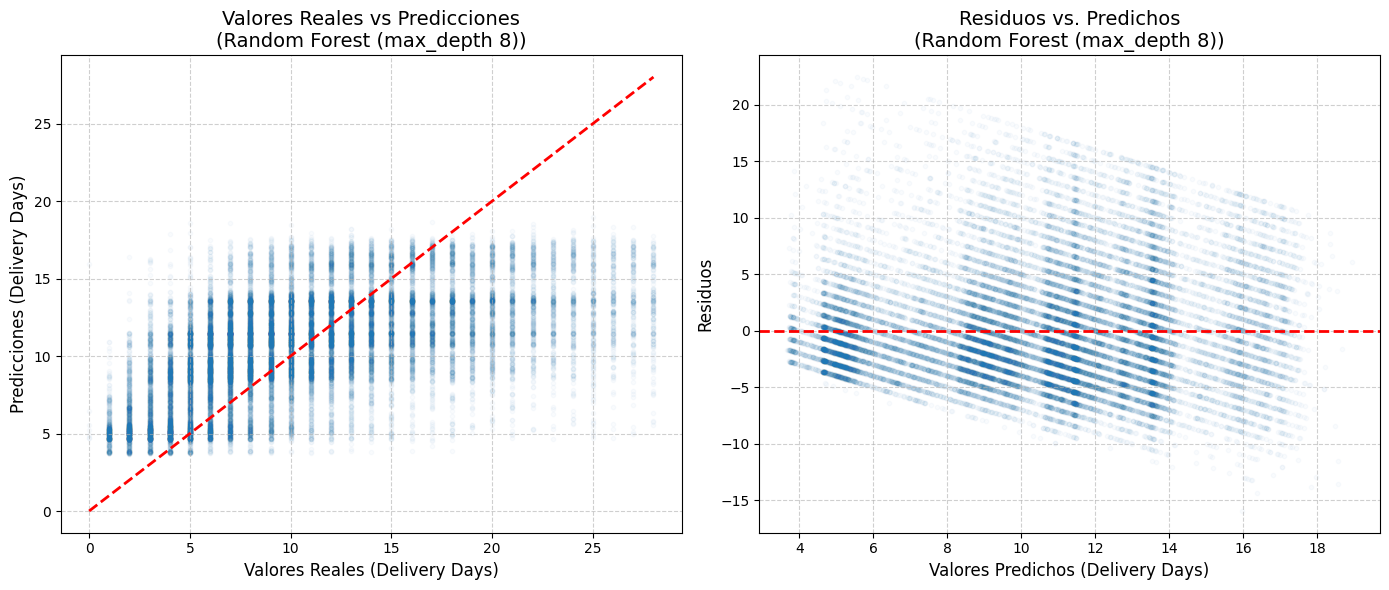


--- Evaluación de Random Forest (max_depth 8) ---
Mean Squared Error (MSE):     25.008302
Root Mean Squared Error (RMSE): 5.000830
Mean Absolute Error (MAE):    3.873792
R-squared (R²):               0.315363
--------------------------------------------------


In [61]:
# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 8)

# Entrenamiento de modelo
rf_regressor.fit(X_days_train, Y_days_train)

# Predicciones con el modelo
Y_pred = rf_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    target_column_name='Delivery Days',
    model_name='Random Forest (max_depth 8)'
)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    model_name='Random Forest (max_depth 8)'
)

Este modelo mejoro marginalmente el R2, obteniendo un resultado de 0.315. Además, en la gráfica de valores predichos vs actuales parece empezar a tener predicciones más precisas para los valores más altos en comparación al anterior. Luego, la gráfica de residuos parece tener una disribución un poco más uniforme en comparación al modelo anterior. Esto nos indica una mejora, sin embargo podemos seguir lejos de los parámetros óptimos.

**Modelo Gridsearch con CV**

Descripcion del modelo


--- Evaluación de RF (CV) ---
Mean Squared Error (MSE):     24.296790
Root Mean Squared Error (RMSE): 4.929177
Mean Absolute Error (MAE):    3.798691
R-squared (R²):               0.334842
------------------------------


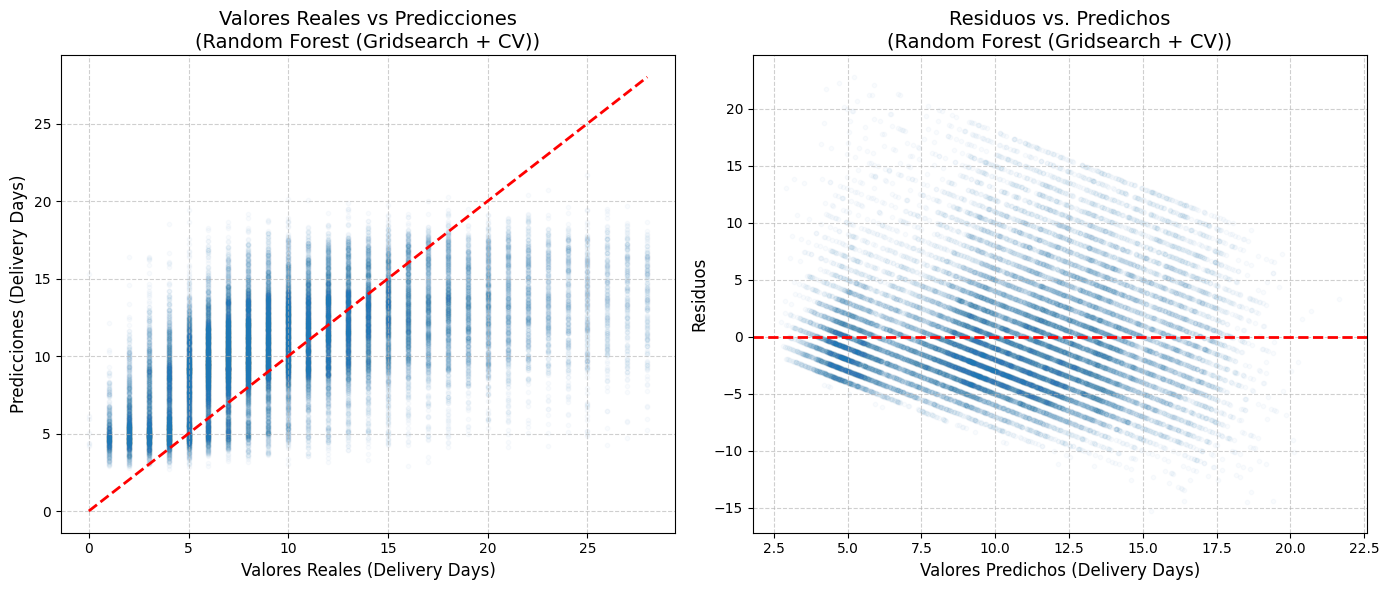

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time

param_grid_less_extensive = {
    'n_estimators': [100, 200],
    'max_depth': [15, 25, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_regressor_cv = RandomForestRegressor(random_state=42)

grid_search_cv = GridSearchCV(
    estimator=rf_regressor_cv,
    param_grid=param_grid_less_extensive,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)

grid_search_cv.fit(X_days_train, Y_days_train)

best_rf_cv = grid_search_cv.best_estimator_

Y_pred_cv = best_rf_cv.predict(X_days_test)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv,
    model_name='RF (CV)'
)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv,
    target_column_name='Delivery Days',
    model_name='Random Forest (Gridsearch + CV)'
)

Este modelo tiene un R2 de 0.335, dandonos una mejora sobre el anterior. Sin embargo, seguimos teniendo algunos de los mismos problemas. Para los valores mas altos, este modelo parece incapaz de aprender sobre como clasificarlos correctamente. Esto se puede deber a la menor cantidad de modelos de este tipo, o falta de características distintivas. 

**Análisis Comparativo**

El modelo con validación cruzada probó tener un rendimiento superior, sin embargo no fue una distinción tan clara. Esto se puede deber a limitaciones dentro de los datos (dónde por ejemplo, existen muy pocos datos sobre casos con días de entrega muy altos) o una exploración limitada sobre los parámetros del modelo. En general, podemos concluir que la variación de parámetros tuvo un rendimiento significativamente superior a los parámetros iniciales y la lo mismo se puede decir sobre la validación cruzada.

### Review Score

**Modelo 'Baseline'**

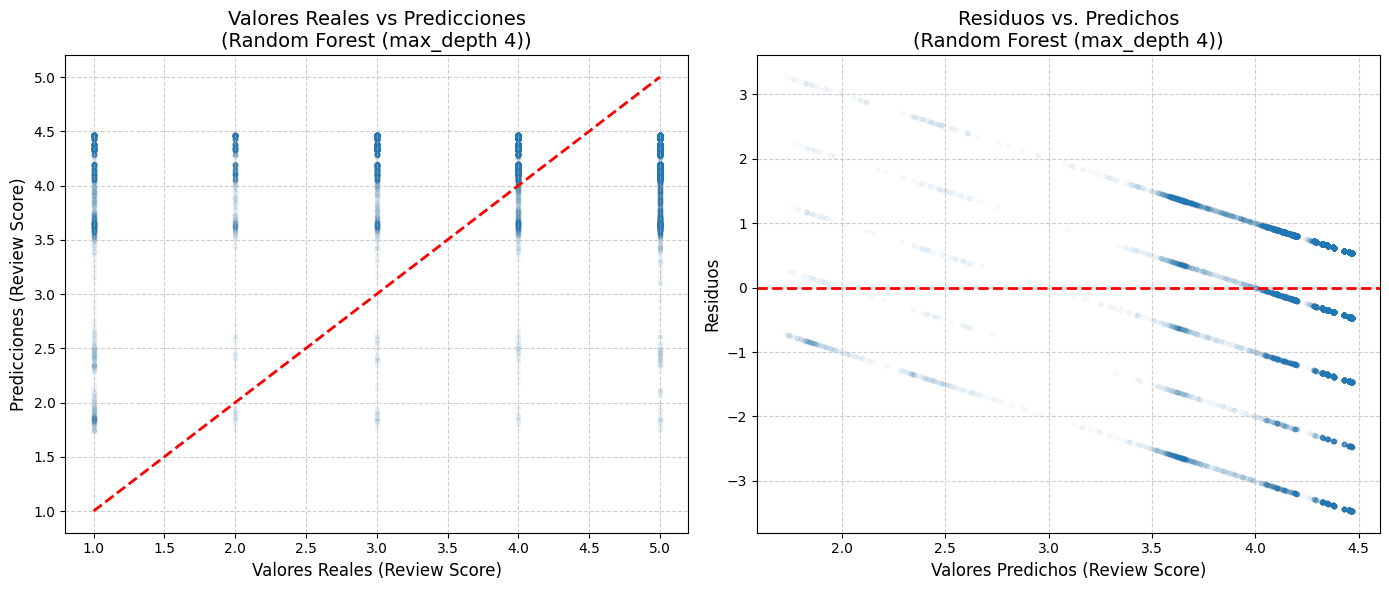


--- Evaluación de Random Forest (max_depth 4) ---
Mean Squared Error (MSE):     1.276440
Root Mean Squared Error (RMSE): 1.129796
Mean Absolute Error (MAE):    0.867017
R-squared (R²):               0.098434
--------------------------------------------------


In [63]:
rf_regressor_baseline_review = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=4)

rf_regressor_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review = rf_regressor_baseline_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review,
    target_column_name='Review Score',
    model_name='Random Forest (max_depth 4)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review,
    model_name='Random Forest (max_depth 4)'
)

El modelo tiene un R2 de 0.09, indicando que no aprendió prácticamente nada. Esto nos indica que es absolutamente necesario cambiar los parámetros, al igual que la existencia de limitaciones debido a la distribución de la variable objetivo. Al tener la mayoría de los puntajes en categorías más altas, el modelo predice estas categorías con una frecuencia demasiado alta.

**Modelo con Nuevos Parametros**

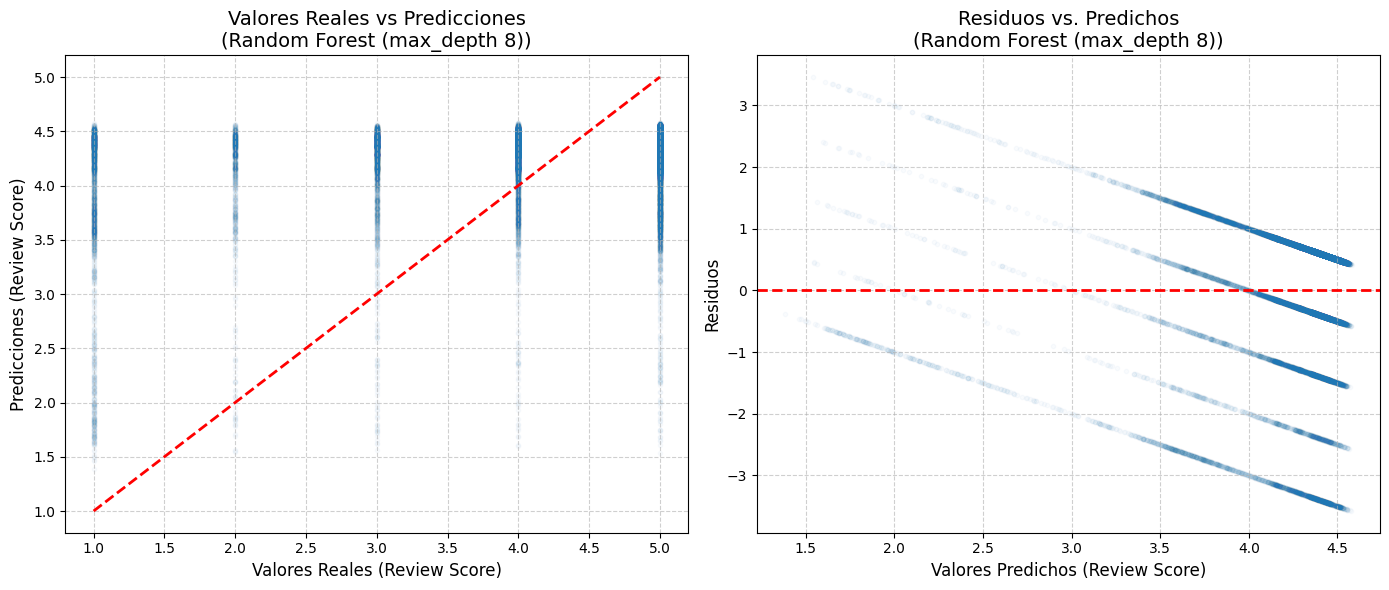


--- Evaluación de Random Forest (max_depth 8) ---
Mean Squared Error (MSE):     1.269253
Root Mean Squared Error (RMSE): 1.126612
Mean Absolute Error (MAE):    0.862917
R-squared (R²):               0.103510
--------------------------------------------------


In [64]:
rf_regressor_baseline_review = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=8)

rf_regressor_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review = rf_regressor_baseline_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review,
    target_column_name='Review Score',
    model_name='Random Forest (max_depth 8)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review,
    model_name='Random Forest (max_depth 8)'
)

Este modelo mejora marginalmente en comparación al anterior, mostrando problemas similares para realizar predicciones.

**Modelo Gridsearch con CV**


--- Evaluación de Random Forest (Gridsearch + CV) ---
Mean Squared Error (MSE):     1.270322
Root Mean Squared Error (RMSE): 1.127086
Mean Absolute Error (MAE):    0.861710
R-squared (R²):               0.102755
------------------------------------------------------
Best Parameters found: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation RMSE: nan


/tmp/ipykernel_3773/1415217723.py:36: RuntimeWarning: invalid value encountered in sqrt
  print(f"Best Cross-Validation RMSE: {np.sqrt(-grid_search_cv_review.best_score_):.4f}")


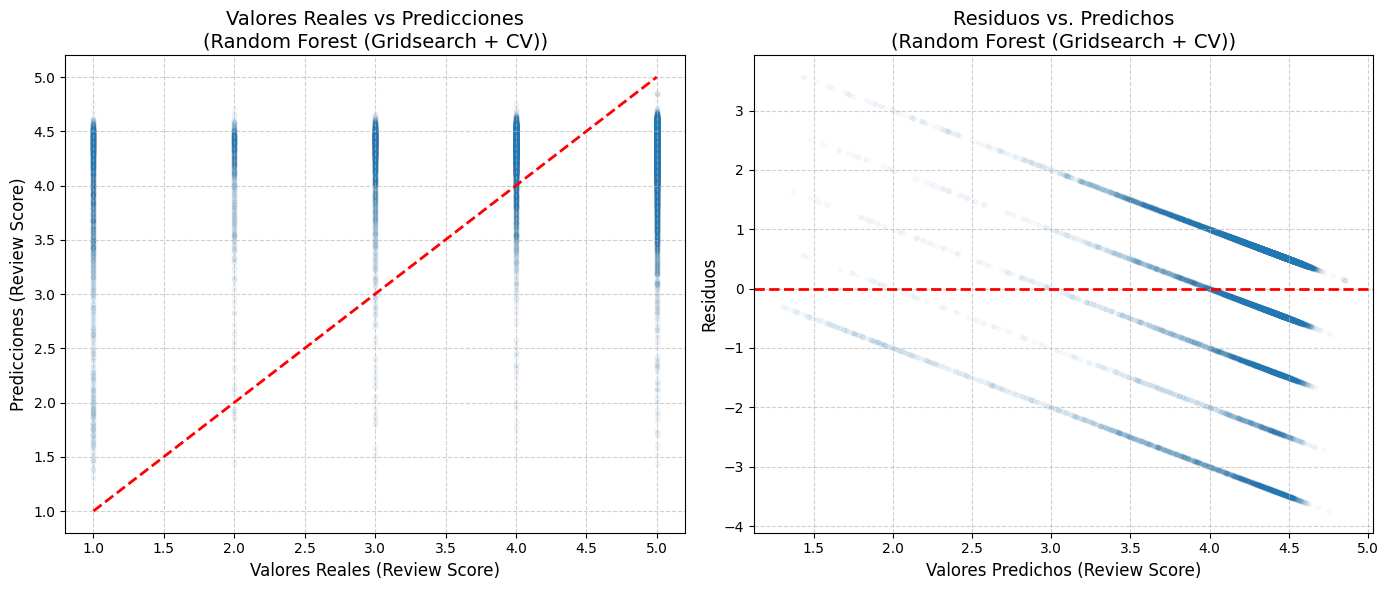

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import time

param_grid_less_extensive = {
    'n_estimators': [100, 200],
    'max_depth': [15, 25, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_regressor_cv_review = RandomForestRegressor(random_state=42)

grid_search_cv_review = GridSearchCV(
    estimator=rf_regressor_cv_review,
    param_grid=param_grid_less_extensive,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_cv_review.fit(X_review_train, Y_review_train)

best_rf_cv_review = grid_search_cv_review.best_estimator_

Y_pred_cv_review = best_rf_cv_review.predict(X_review_test)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_cv_review,
    model_name='Random Forest (Gridsearch + CV)'
)

print("Best Parameters found:", grid_search_cv_review.best_params_)
print(f"Best Cross-Validation RMSE: {np.sqrt(-grid_search_cv_review.best_score_):.4f}")

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_cv_review,
    target_column_name='Review Score',
    model_name='Random Forest (Gridsearch + CV)'
)

Este modelo produjo resultados casi idénticos al anterior, esto nos indica que la validación cruzada no generó alguna mejora sobre el modelo. Esto se puede dar en casos similares a este, dónde puede que la elección de utilizar un modelo de regresión para predecir este tipo de variables objetivo no es adeucada.

**Análisis Comparativo**

En general, estos modelos probaron no ser adecuados para resolver el problema de predecir puntaje de review. Esto debido a dos factores principales:

- Este problema puede que sea resuelto utilizando modelos de clasificación en lugar de regresión
- La distribución de la variable objetivo tiene un número mucho más alto de reviews altos en comparación a bajos

En cuánto a la variación de parámetros y validación cruzada, estos métodos probaron no ser efectivos en este caso en específico. Esto nos indica que nuestra variable objetivo puede ser predecida de mejor manera con un modelo de clasificación, o que la distribución de esta debe ser examinada para poder generar modelos efectivos.

## KNN

### Delivery Days

**Modelo 'Baseline'**

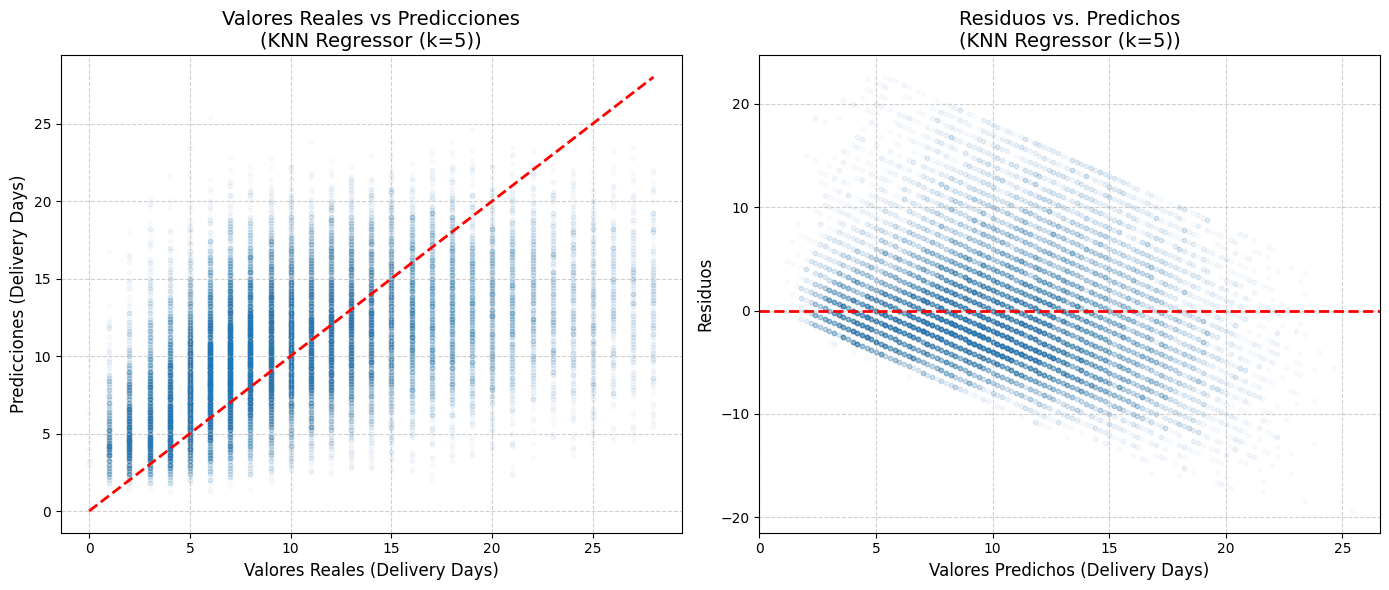


--- Evaluación de KNN Regressor (k=5) ---
Mean Squared Error (MSE):     29.122045
Root Mean Squared Error (RMSE): 5.396484
Mean Absolute Error (MAE):    4.144471
R-squared (R²):               0.202743
------------------------------------------


In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

knn_regressor = KNeighborsRegressor(n_neighbors=5)

knn_regressor.fit(X_days_train, Y_days_train)
Y_pred_knn = knn_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    target_column_name='Delivery Days',
    model_name='KNN Regressor (k=5)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    model_name='KNN Regressor (k=5)'
)

Este modelo inicial tiene indicadores prometedores, parece captar el trend inicial entre 0-15 días al tener una concentración cercana a la línea perfecta. Sin embargo, continúa con algunos de los dolores de los modelos anteriores. Para deliveries más largos, le es difícil realizar predicciones y según la gráfica de residuales parece tener una dificultad más grande para predecir mientras su valor aumenta.

**Modelo con Nuevos Parametros**

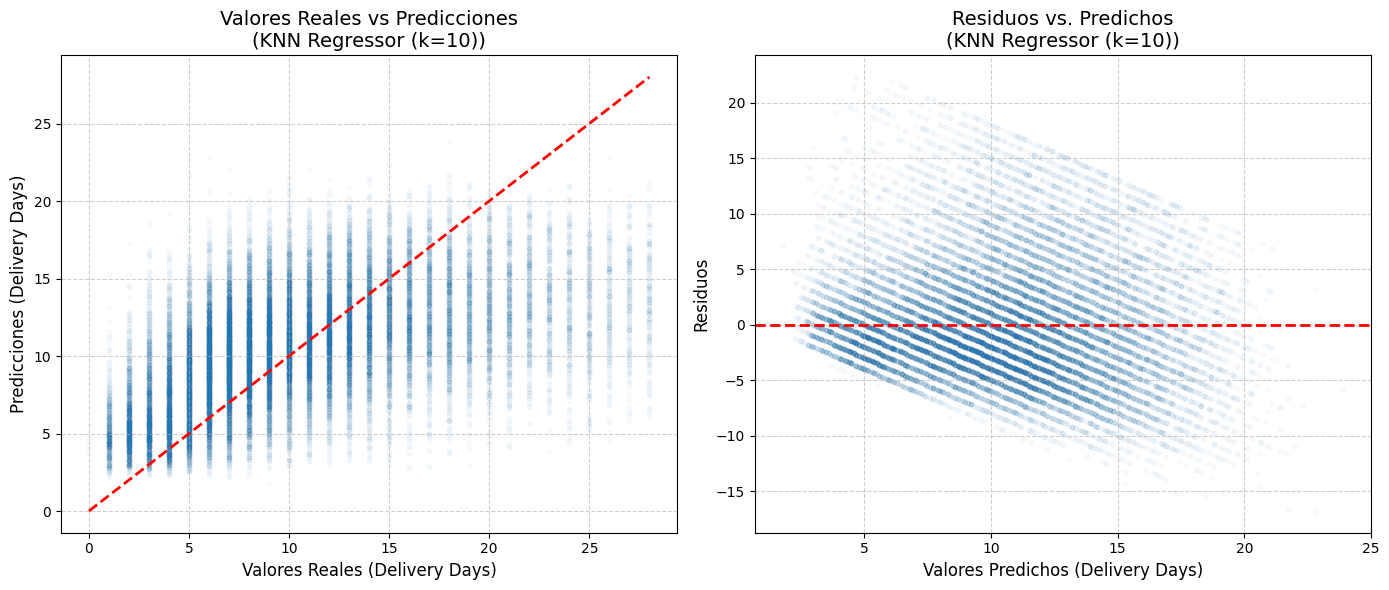


--- Evaluación de KNN Regressor (k=10) ---
Mean Squared Error (MSE):     27.059244
Root Mean Squared Error (RMSE): 5.201850
Mean Absolute Error (MAE):    4.011763
R-squared (R²):               0.259215
-------------------------------------------


In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

knn_regressor = KNeighborsRegressor(n_neighbors=10)

knn_regressor.fit(X_days_train, Y_days_train)
Y_pred_knn = knn_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    target_column_name='Delivery Days',
    model_name='KNN Regressor (k=10)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    model_name='KNN Regressor (k=10)'
)

Este modelo ofrece una mejora significativa sobre el anterior, con un R2 de 0.26. Parece captar el trend inicial de manera correcta pero comparte algunos de los errores del modelo anterior. Observando la gráfica de residuos, sigue teniendo problema para trabajar con valores más altos de Delivery Days. Sin embargo, podemos concluir que el tener un parámetro de K más alto resultó en un modelo más preciso.

**Modelo Gridsearch con CV**

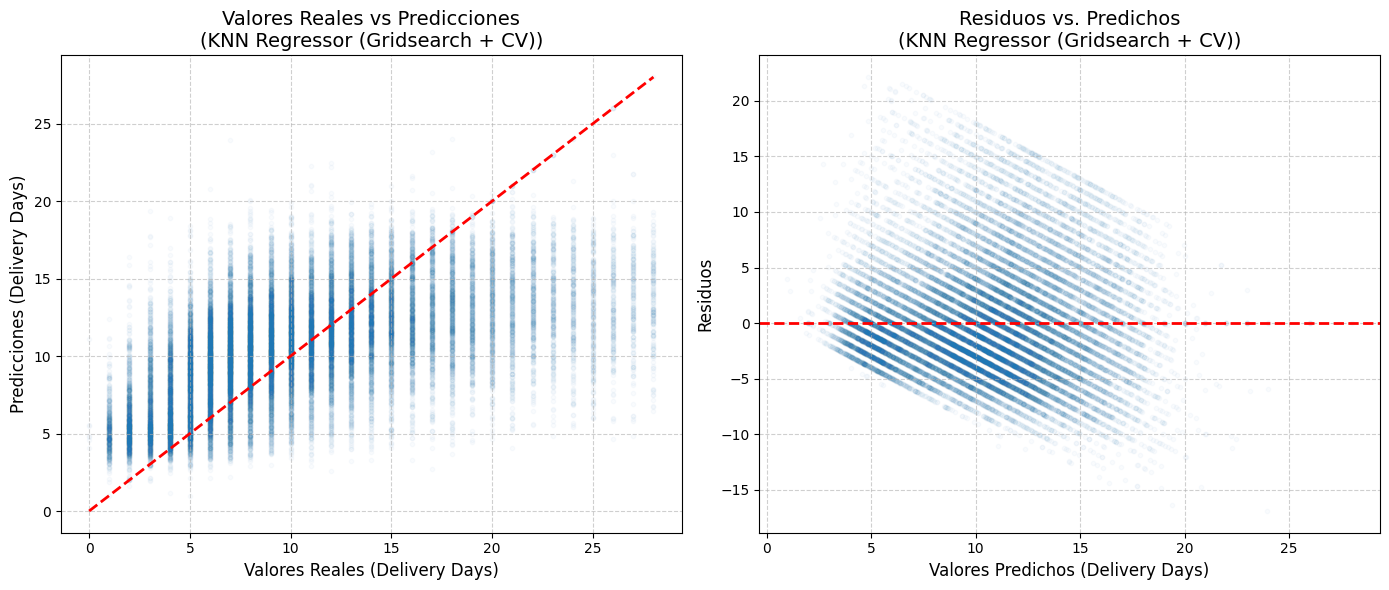


--- Evaluación de KNN Regressor (Gridsearch + CV) ---
Mean Squared Error (MSE):     25.627894
Root Mean Squared Error (RMSE): 5.062400
Mean Absolute Error (MAE):    3.886606
R-squared (R²):               0.298401
------------------------------------------------------


In [68]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import time
import numpy as np

param_grid_knn = {
    'n_neighbors': [13, 16, 19, 21, 23, 27, 30],
    'weights': ['uniform', 'distance']
}

knn_regressor_cv = KNeighborsRegressor()

grid_search_cv_knn = GridSearchCV(
    estimator=knn_regressor_cv,
    param_grid=param_grid_knn,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_cv_knn.fit(X_days_train, Y_days_train)

best_knn_cv = grid_search_cv_knn.best_estimator_

Y_pred_cv_knn = best_knn_cv.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv_knn,
    target_column_name='Delivery Days',
    model_name='KNN Regressor (Gridsearch + CV)'
)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv_knn,
    model_name='KNN Regressor (Gridsearch + CV)'
)


El modelo utilizando validación cruzada trajo una mejora en los resultados en comparación al anterior, tiene un R2 de 0.298 en comparación a 0.26 del anterior. Esto nos indica que una validación cruzada resultó en un modelo más efectivo y que una búsqueda en un campo de parámetros más amplio también contribuyó a esto. En cuánto a la gráfica de residuales, la tendencia general (dónde la gráfica está más oscura) parece estar distribuida más uniformemente que el modelo anterior. Sin embargo, seguimos teniendo regiones más claras (menos densas) que siguen algunos patrones. Esto nos indica que el modelo sigue siendo incapaz de detectar algunos patrones dentro de nuestros datos.

**Análisis Comparativo**

En el caso de la regresión KNN, la variación de parámetros ofreció una mejora significativa sobre el modelo. Además, el explorar un espacio más amplio de parámetros utilizando Gridsearch y validación cruzada probó ser efectivo. En general, este algoritmo ofrece una precisión bastante similar a otros modelos como Random Forest a un costo computacional sumamente bajo en comparación.

### Review Score

**Modelo 'Baseline'**

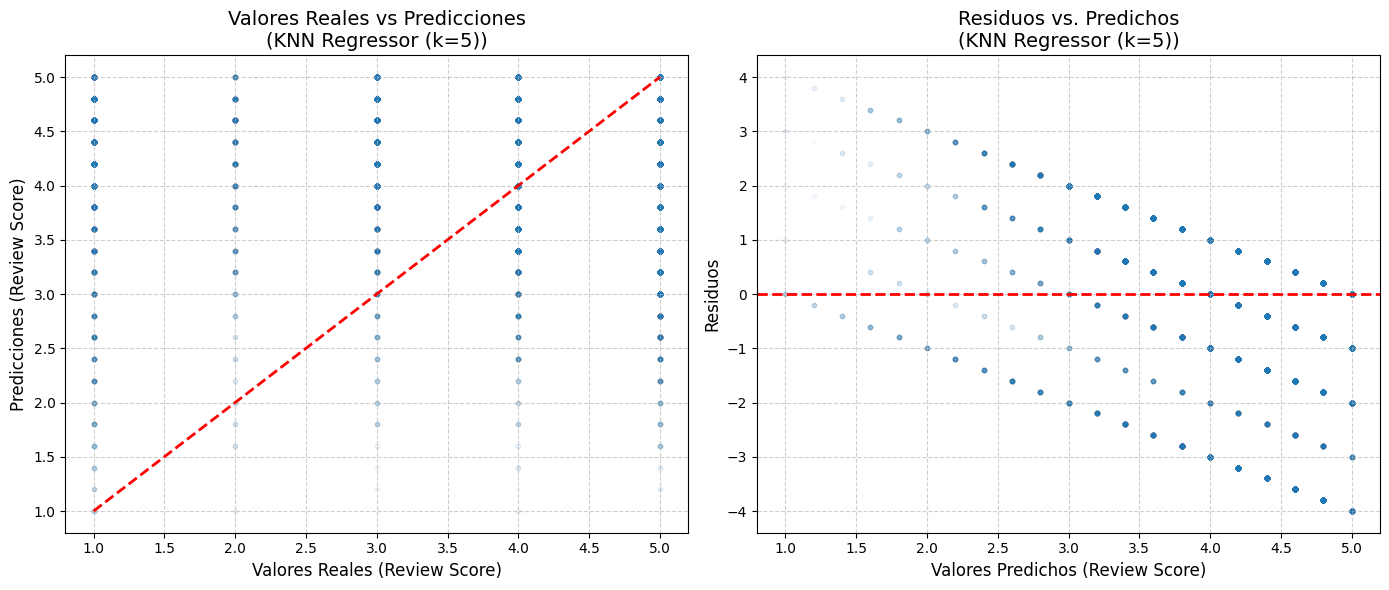


--- Evaluación de KNN Regressor (k=5) ---
Mean Squared Error (MSE):     1.531908
Root Mean Squared Error (RMSE): 1.237703
Mean Absolute Error (MAE):    0.905049
R-squared (R²):               -0.082006
------------------------------------------


In [69]:
from sklearn.neighbors import KNeighborsRegressor

knn_regressor_baseline_review = KNeighborsRegressor(n_neighbors=5)
knn_regressor_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review_knn = knn_regressor_baseline_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_knn,
    target_column_name='Review Score',
    model_name='KNN Regressor (k=5)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_knn,
    model_name='KNN Regressor (k=5)'
)

El modelo inicial utilizando KNN es muy claramente incapaz de realizar alguna predicción, no parece existir alguna centralidad o concentración más alta de predicciones según la línea perfecta y tiene un R2 negativo. Podemos probar aumentando el número de K para ver si el siguiente modelo es más apto.

**Modelo con Nuevos Parametros**

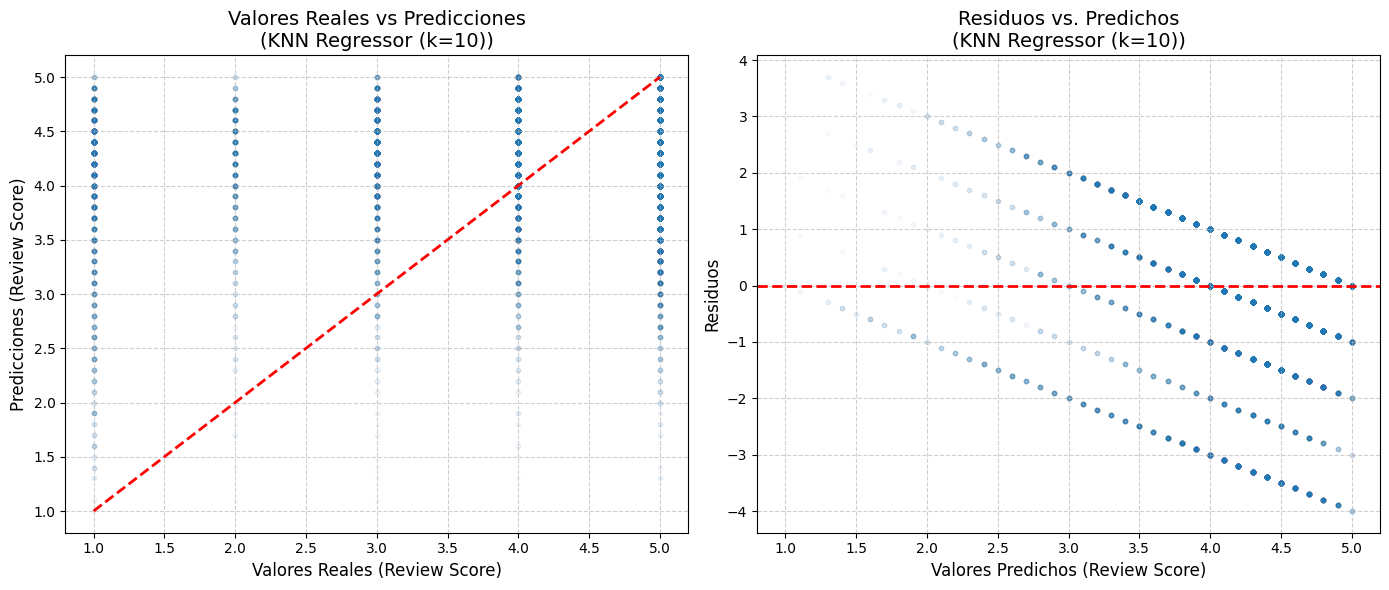


--- Evaluación de KNN Regressor (k=10) ---
Mean Squared Error (MSE):     1.400328
Root Mean Squared Error (RMSE): 1.183355
Mean Absolute Error (MAE):    0.883338
R-squared (R²):               0.010931
-------------------------------------------


In [70]:
from sklearn.neighbors import KNeighborsRegressor

knn_regressor_baseline_review = KNeighborsRegressor(n_neighbors=10)
knn_regressor_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review_knn = knn_regressor_baseline_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_knn,
    target_column_name='Review Score',
    model_name='KNN Regressor (k=10)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_knn,
    model_name='KNN Regressor (k=10)'
)

Este modelo ofrece mejoras marginales, ya que sigue sin poder realizar predicciones. Sin embargo, podemos utilizar validación cruzada con un Gridsearch para buscar parámetros más adecuados.

**Modelo Gridsearch con CV**

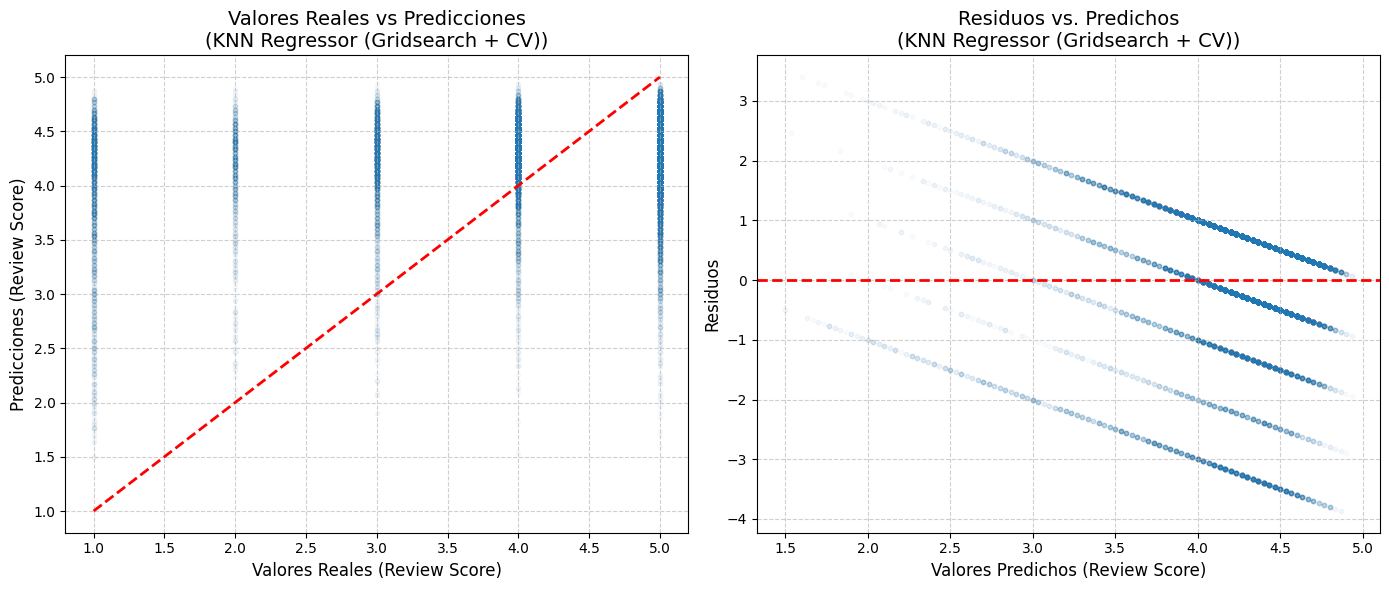


--- Evaluación de KNN Regressor (Gridsearch + CV) ---
Mean Squared Error (MSE):     1.316404
Root Mean Squared Error (RMSE): 1.147346
Mean Absolute Error (MAE):    0.870478
R-squared (R²):               0.070207
------------------------------------------------------


In [71]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import time
import numpy as np

param_grid_knn_less_extensive = {
    'n_neighbors': [13, 16, 19, 21, 23, 27, 30],
    'weights': ['uniform', 'distance']
}

knn_regressor_cv_review = KNeighborsRegressor()

grid_search_cv_knn_review = GridSearchCV(
    estimator=knn_regressor_cv_review,
    param_grid=param_grid_knn_less_extensive,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_cv_knn_review.fit(X_review_train, Y_review_train)

best_knn_cv_review = grid_search_cv_knn_review.best_estimator_

Y_pred_cv_knn_review = best_knn_cv_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_cv_knn_review,
    target_column_name='Review Score',
    model_name='KNN Regressor (Gridsearch + CV)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_cv_knn_review,
    model_name='KNN Regressor (Gridsearch + CV)'
)

Este modelo ofrece mejoras significativas sobre el anterior, con un R2 más alto al anterior. Además, es el primer modelo utilizando KNN que muestra una diferencia en las concentraciones de predicciones para cada valor real. Sin embargo, hasta el momento toda la evidencia indica que los modelos de regresión no son aptos para resolver el problema de predicción de Review Score.

**Análisis Comparativo**

El modelo KNN muestra un desempeño significativamente mejor utilizando validación cruzada, esto nos indica que es altamente dependiente de los parámetros y el encontrar valores óptimos para estos puede implicar búsquedas amplias. Sin embargo, seguimos opinando que los modelos de regresión no son el approach adecuado para esta problemática.

## SVR

### Delivery Days

**Modelo 'Baseline'**

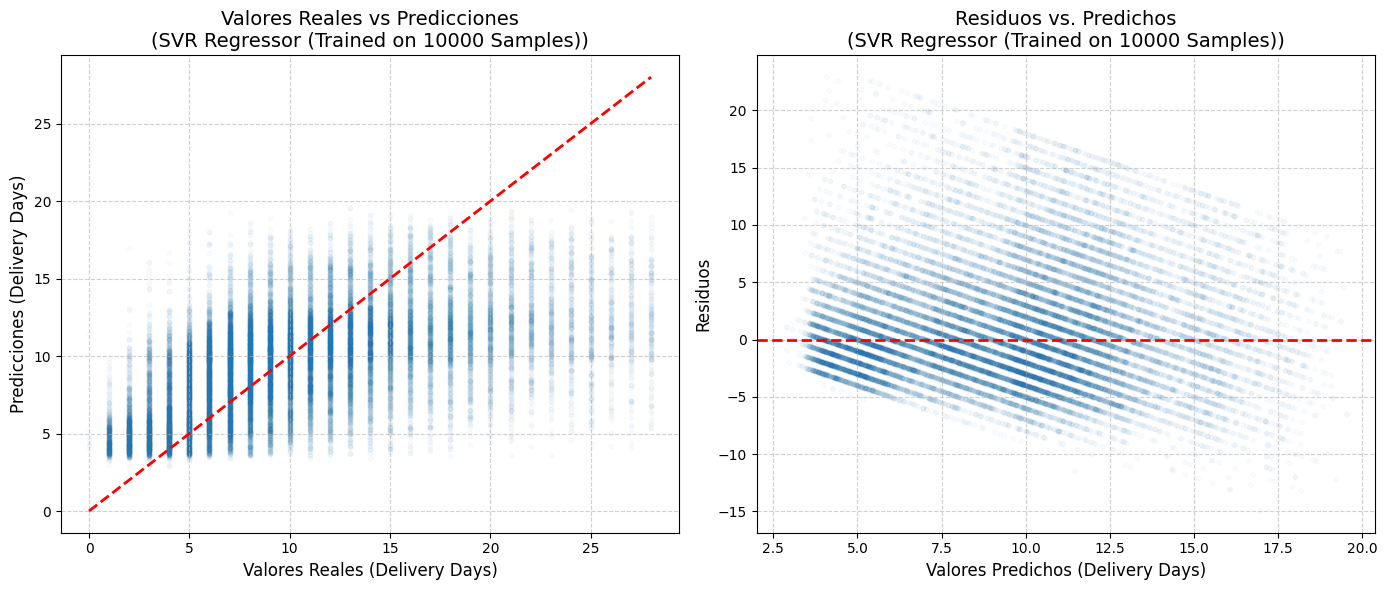


--- Evaluación de SVR Regressor (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     26.907487
Root Mean Squared Error (RMSE): 5.187243
Mean Absolute Error (MAE):    3.858264
R-squared (R²):               0.263370
---------------------------------------------------------------


In [72]:
from sklearn.svm import SVR
import pandas as pd

sample_size = 10000
if isinstance(sample_size, int):
    if sample_size > len(X_days_train):
        X_train_sample = X_days_train
        Y_train_sample = Y_days_train
    else:
        sample_indices = X_days_train.sample(n=sample_size, random_state=42).index
        X_train_sample = X_days_train.loc[sample_indices]
        Y_train_sample = Y_days_train.loc[sample_indices]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample = X_days_train.sample(frac=sample_size, random_state=42)
    Y_train_sample = Y_days_train.loc[X_train_sample.index]
else:
    X_train_sample = X_days_train
    Y_train_sample = Y_days_train


svr_regressor_sample = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1)

svr_regressor_sample.fit(X_train_sample, Y_train_sample)

Y_pred_svr_sample = svr_regressor_sample.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_sample,
    target_column_name='Delivery Days',
    model_name=f'SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_sample,
    model_name=f'SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)


Este modelo es el mejor modelo baseline que hemos tenido hasta el momento (R2 de 0.26), parece captar la relación entre pocos días (4-15) de manera bastante adecuada según la gráfica de predichos vs reales y la distribución de los residuales es bastante uniforme en cuánto a la concentración principal. Podemos probar con diferentes parámetros para intentar encontrar un modelo aún mejor.

**Modelo con Nuevos Parametros**

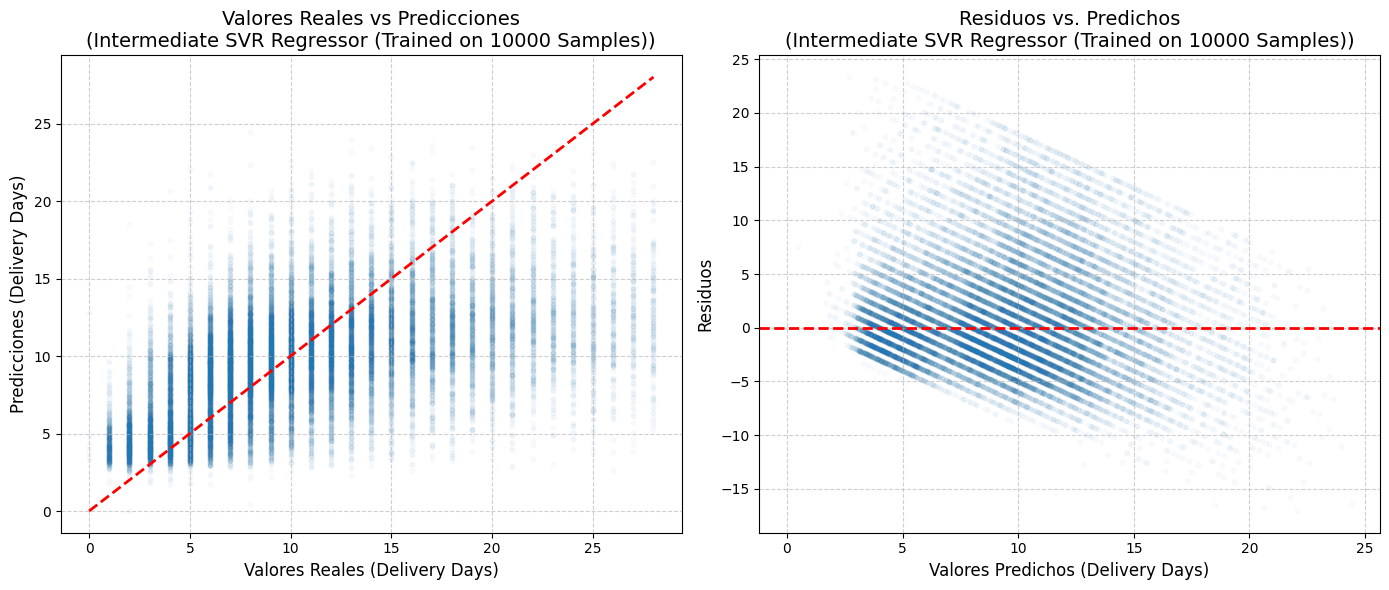


--- Evaluación de Intermediate SVR Regressor (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     27.287108
Root Mean Squared Error (RMSE): 5.223706
Mean Absolute Error (MAE):    3.886808
R-squared (R²):               0.252977
----------------------------------------------------------------------------


In [73]:
from sklearn.svm import SVR
import pandas as pd

sample_size = 10000
if isinstance(sample_size, int):
    if sample_size > len(X_days_train):
        X_train_sample = X_days_train
        Y_train_sample = Y_days_train
    else:
        sample_indices = X_days_train.sample(n=sample_size, random_state=42).index
        X_train_sample = X_days_train.loc[sample_indices]
        Y_train_sample = Y_days_train.loc[sample_indices]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample = X_days_train.sample(frac=sample_size, random_state=42)
    Y_train_sample = Y_days_train.loc[X_train_sample.index]
else:
    X_train_sample = X_days_train
    Y_train_sample = Y_days_train

svr_regressor_intermediate = SVR(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    epsilon=0.05
)

svr_regressor_intermediate.fit(X_train_sample, Y_train_sample)

Y_pred_svr_intermediate = svr_regressor_intermediate.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_intermediate,
    target_column_name='Delivery Days',
    model_name=f'Intermediate SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_intermediate,
    model_name=f'Intermediate SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)


Al variar los parámetros, obtenemos resultados sumamente similares a los parámetros baseline. Esto nos puede indicar dos cosas,

- Los parámetros baseline eran bastante adecuados para realizar predicciones sobre el modelo
- Debemos realizar una búsqueda más amplia sobre diferentes parámetros e implementar validación cruzada

**Gridsearch con CV**

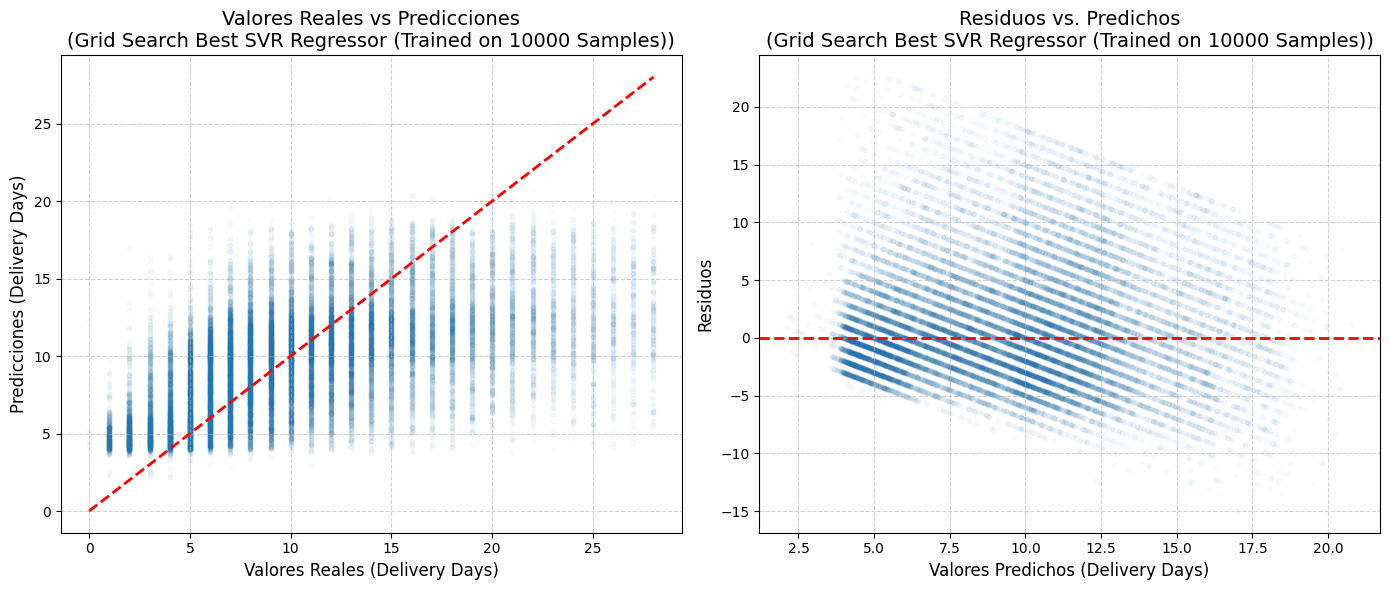


--- Evaluación de Grid Search Best SVR Regressor (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     26.840644
Root Mean Squared Error (RMSE): 5.180796
Mean Absolute Error (MAE):    3.853952
R-squared (R²):               0.265200
--------------------------------------------------------------------------------


In [74]:
from sklearn.svm import SVR
import pandas as pd
from sklearn.model_selection import GridSearchCV

sample_size = 10000
if isinstance(sample_size, int):
    if sample_size > len(X_days_train):
        X_train_sample = X_days_train
        Y_train_sample = Y_days_train
    else:
        sample_indices = X_days_train.sample(n=sample_size, random_state=42).index
        X_train_sample = X_days_train.loc[sample_indices]
        Y_train_sample = Y_days_train.loc[sample_indices]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample = X_days_train.sample(frac=sample_size, random_state=42)
    Y_train_sample = Y_days_train.loc[X_train_sample.index]
else:
    X_train_sample = X_days_train
    Y_train_sample = Y_days_train


param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.05, 0.1, 0.2, 0.5]
}

svr = SVR(kernel='rbf')

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train_sample, Y_train_sample)

best_params = grid_search.best_params_
best_svr_model = grid_search.best_estimator_

Y_pred_best_svr = best_svr_model.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_best_svr,
    target_column_name='Delivery Days',
    model_name=f'Grid Search Best SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_best_svr,
    model_name=f'Grid Search Best SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)



El rendimiento de este modelo es marginalmente mejor a los anteriores, sigue presentando características similares. Esto nos lleva a la conclusión que los parámetros elegidos inicialmente fueron adecuados para el set de datos y que SVR puede verse afectado levemente por la variación de parámetros

**Análisis Comparativo**

El modelo base de SVR comprobó ser bastante efectivo, sin embargo, al momento de variar parámetros no se encontraron mejoras significativas. A pesar de implementar validación cruzada, los resultados fueron sumamente similares.

### Review Score

**Modelo 'Baseline'**

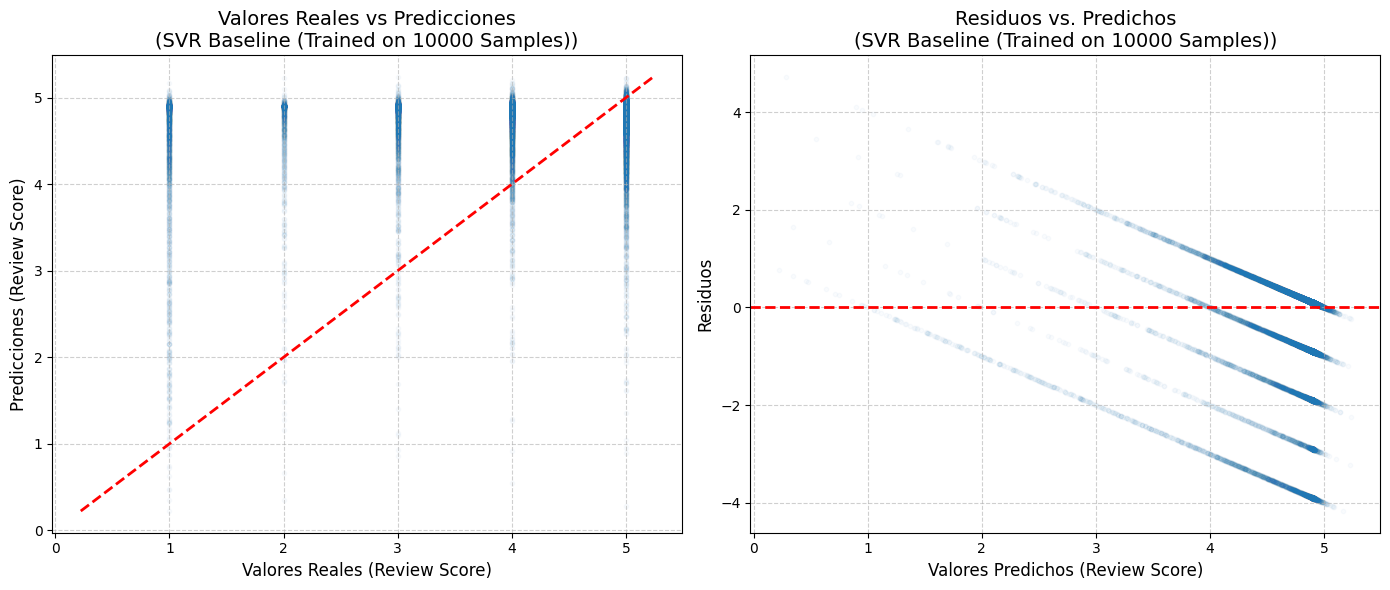


--- Evaluación de SVR Baseline (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     1.540011
Root Mean Squared Error (RMSE): 1.240972
Mean Absolute Error (MAE):    0.749354
R-squared (R²):               -0.087729
--------------------------------------------------------------


In [75]:
from sklearn.svm import SVR
import pandas as pd

sample_size = 10000

if sample_size > len(X_review_train):
    X_train_sample_review = X_review_train
    Y_train_sample_review = Y_review_train
else:
    sample_indices_review = X_review_train.sample(n=sample_size, random_state=42).index
    X_train_sample_review = X_review_train.loc[sample_indices_review]
    Y_train_sample_review = Y_review_train.loc[sample_indices_review]

svr_regressor_baseline_review = SVR()

svr_regressor_baseline_review.fit(X_train_sample_review, Y_train_sample_review)

Y_pred_baseline_review_svr = svr_regressor_baseline_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_svr,
    target_column_name='Review Score',
    model_name=f'SVR Baseline (Trained on {len(X_train_sample_review)} Samples)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_svr,
    model_name=f'SVR Baseline (Trained on {len(X_train_sample_review)} Samples)'
)


En este caso, el modelo baseline de SVR parece incapaz de realizar predicciones. Debido a esto, vamos a probar con otros parámetros para intentar mejorarlo. Según las gráficas generadas, únicamente está prediciendo valores entre 4 y 5 para casi todos los valores reales.

**Modelo con Nuevos Parametros**

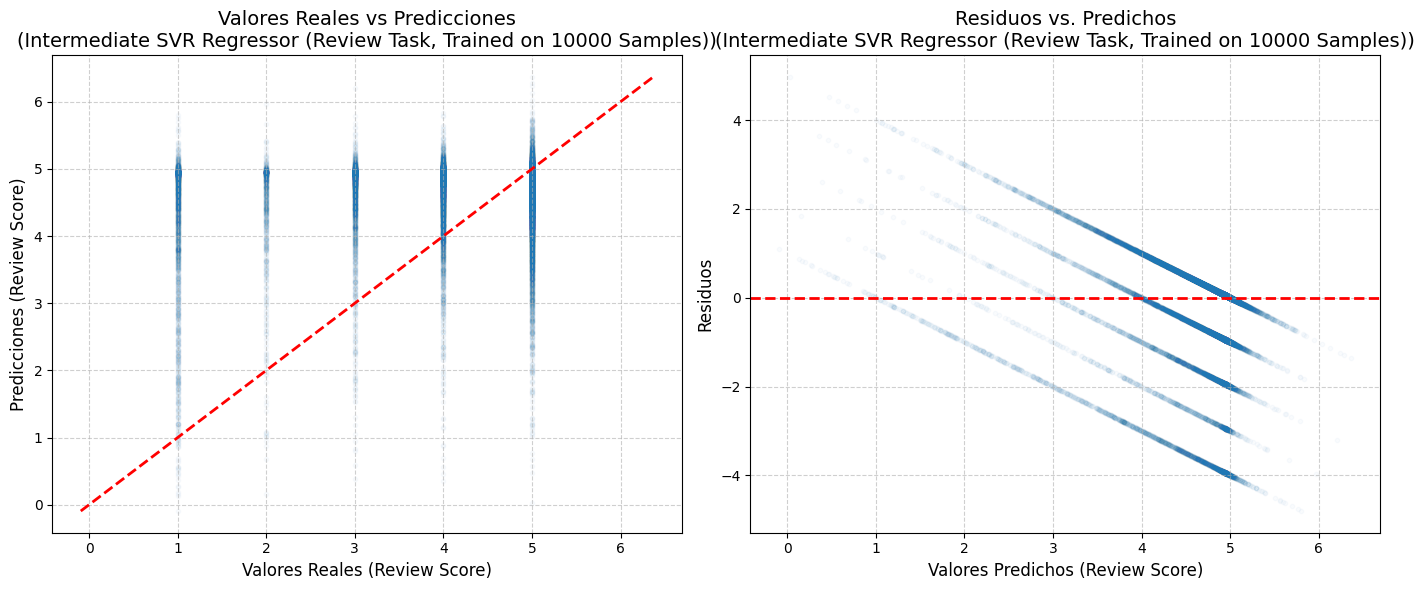


--- Evaluación de Intermediate SVR Regressor (Review Task, Trained on 10000 Samples) ---
Mean Squared Error (MSE):     1.579027
Root Mean Squared Error (RMSE): 1.256593
Mean Absolute Error (MAE):    0.777887
R-squared (R²):               -0.115287
-----------------------------------------------------------------------------------------


In [76]:
from sklearn.svm import SVR
import pandas as pd

sample_size = 10000

if isinstance(sample_size, int):
    if sample_size > len(X_review_train):
        X_train_sample_review = X_review_train
        Y_train_sample_review = Y_review_train
    else:
        sample_indices_review = X_review_train.sample(n=sample_size, random_state=42).index
        X_train_sample_review = X_review_train.loc[sample_indices_review]
        Y_train_sample_review = Y_review_train.loc[sample_indices_review]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample_review = X_review_train.sample(frac=sample_size, random_state=42)
    Y_train_sample_review = Y_review_train.loc[X_train_sample_review.index]
else:
    X_train_sample_review = X_review_train
    Y_train_sample_review = Y_review_train

svr_regressor_intermediate_review = SVR(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    epsilon=0.05
)

svr_regressor_intermediate_review.fit(X_train_sample_review, Y_train_sample_review)

Y_pred_intermediate_review_svr = svr_regressor_intermediate_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_svr,
    target_column_name='Review Score',
    model_name=f'Intermediate SVR Regressor (Review Task, Trained on {len(X_train_sample_review)} Samples)'
)
print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_svr,
    model_name=f'Intermediate SVR Regressor (Review Task, Trained on {len(X_train_sample_review)} Samples)'
)


Aún variando los parámetros, el modelo parece no poder realizar predicciones correctas. Sigue teniendo los mismos problemas, sobre-prediciendo los valores predominantes dentro del dataset. Podemos realizar un grid-search con validación cruzada para intentar encontrar parámetros más adecuados para el modelo.

**Modelo Gridsearch con CV**

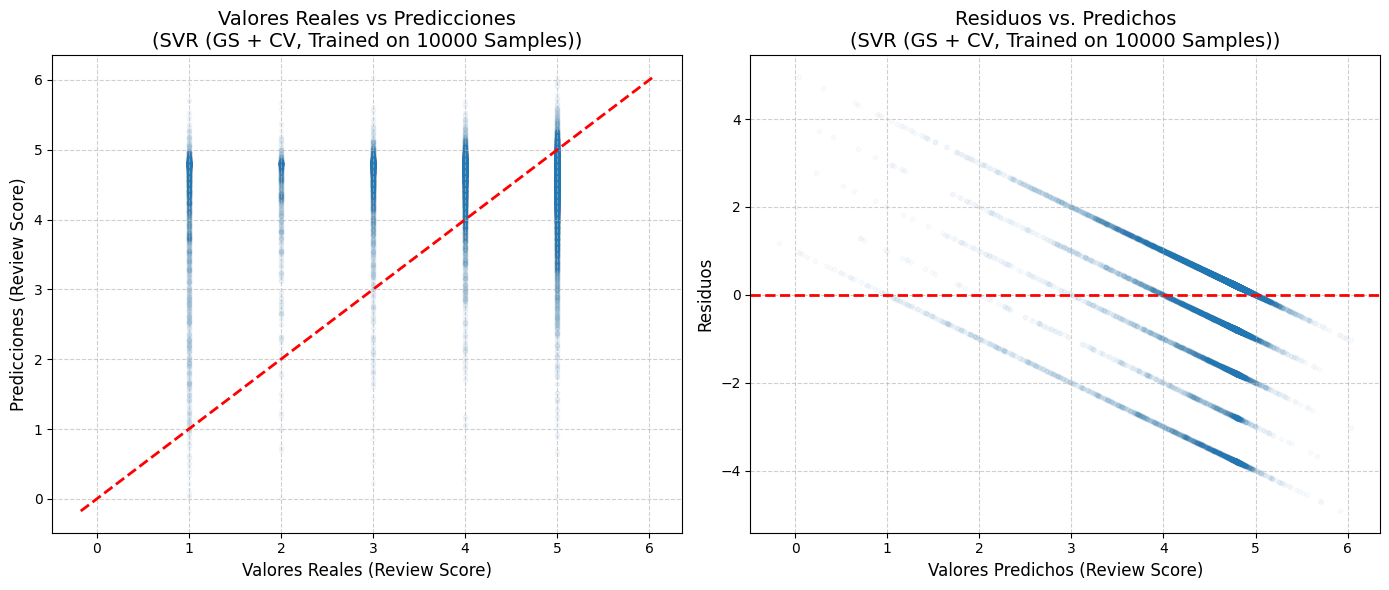


--- Evaluación de SVR (GS + CV, Trained on 10000 Samples) ---
Mean Squared Error (MSE):     1.482814
Root Mean Squared Error (RMSE): 1.217708
Mean Absolute Error (MAE):    0.799763
R-squared (R²):               -0.047330
--------------------------------------------------------------


In [77]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time
import numpy as np
import pandas as pd

param_grid_svr_less_extensive = {
    'C': [0.1, 1, 10],
    'epsilon': [0.05, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

sample_size = 10000

if sample_size > len(X_review_train):
    X_train_sample_review = X_review_train
    Y_train_sample_review = Y_review_train
else:
    sample_indices_review = X_review_train.sample(n=sample_size, random_state=42).index
    X_train_sample_review = X_review_train.loc[sample_indices_review]
    Y_train_sample_review = Y_review_train.loc[sample_indices_review]

svr_regressor_cv_review = SVR()

grid_search_cv_svr_review = GridSearchCV(
    estimator=svr_regressor_cv_review,
    param_grid=param_grid_svr_less_extensive,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_cv_svr_review.fit(X_train_sample_review, Y_train_sample_review)

best_svr_cv_review = grid_search_cv_svr_review.best_estimator_

Y_pred_cv_svr_review = best_svr_cv_review.predict(X_review_test)

plot_regression_results(
    Y_test=Y_review_test,
    Y_pred=Y_pred_cv_svr_review,
    target_column_name='Review Score',
    model_name=f'SVR (GS + CV, Trained on {len(X_train_sample_review)} Samples)'
)

print_regression_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_cv_svr_review,
    model_name=f'SVR (GS + CV, Trained on {len(X_train_sample_review)} Samples)'
)

A pesar de realizar una búsqueda extensiva, el modelo SVR no puede realizar predicciones adecuadas para Review Score. Esto se alinea con modelos anteriores que tampoco pudieron hacerlo, indicando que es un problema más apto para modelos de clasificación. Además, en este caso SVR tuvo un desempeño destacablemente pobre. Esto se puede dar por haber utilizado un sample size más pequeño, dejando aún menos casos de Review Scores bajos y negándole información clave al modelo.

**Análisis Comparativo**

De manera idéntica a los demás modelos, SVR parece no ser capaz de generar predicciones para Review Score. A pesar de variar los parámetros, los puntajes de R2 son sumamente bajos y las gráficas nos indican que el modelo predice valores entre 4 y 5 consistentemente. El utilizar Gridsearch y validación cruzada probó generar un rendimiento superior, pero aún así no adecuado para lo esperado.

### Conclusiones

- El modelo más adecuado para la predicción de Delivery Days fue Random Forest.
- El implementar validación cruzada tuvo efectos positivos y tangibles dentro de Random Forest y KNN, sin embargo para SVR no se obtuvieron mejoras significativas. Esto se puede dar a una elección de parámetros iniciales más adecuada o particularidades del modelo que lo hacen menos dependiente de los parámetros.
- Ninguno de los modelos probó ser efectivo para predecir Review Score, esto nos indica que es un problema potencialmente resuelto de una manera más adecuada por medio de modelos de clasificación.

# Modelos de Clasificacion
En este seccion implementamos los modelos de clasificacion de Regresion Logistica, Arboles de Decision, Random Forest, Naive Bayes, KNN y SVM. Para cada uno de estos modelos implementamos predicciones de

- Review score, el puntaje de 1-5 dejado en los reviews de un pedido
- Satisfaccion del cliente, pedidos con un Review Score >= 4 indican un cliente satisfecho y de lo contrario insatisfecho.
- Delivery delayed, si un pedido se atrasa o no

La evaluación de los modelos se realizó por medio de curvas CAP y puntaje F1 macro ya que el Weighted favorece a los modelos que no predicen valores con menor representación

## Regresion Logistica

### Review Score

**Modelo Baseline**


--- Metrics for Logistic Regression Baseline (Review Score) ---
Accuracy: 0.6172590692561378
Precision: 0.5125516141656742
Recall: 0.6172590692561378
F1-Score: 0.4855379413592648

Classification Report:
              precision    recall  f1-score   support

         1.0       0.37      0.14      0.20      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       0.50      0.00      0.00      5509
         5.0       0.62      0.99      0.76     16771

    accuracy                           0.62     27290
   macro avg       0.30      0.23      0.19     27290
weighted avg       0.51      0.62      0.49     27290

---------------------------------------------------------------


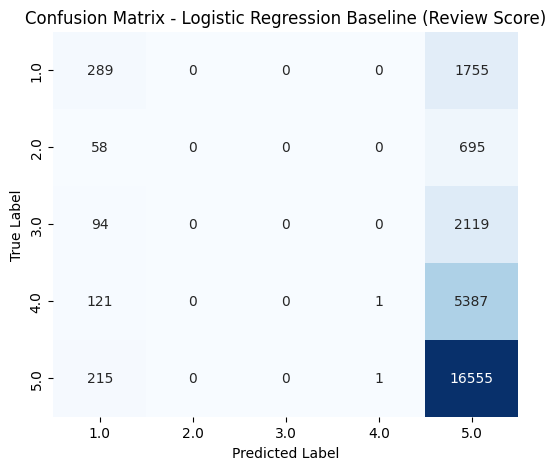

In [78]:
from sklearn.linear_model import LogisticRegression

log_reg_baseline_review = LogisticRegression(
    random_state=42,
    C=10,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)

log_reg_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review_log_reg = log_reg_baseline_review.predict(X_review_test)
Y_pred_proba_baseline_review_log_reg = log_reg_baseline_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_log_reg,
    model_name='Logistic Regression Baseline (Review Score)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_log_reg,
    model_name='Logistic Regression Baseline (Review Score)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_baseline_review_log_reg))))
)


Este modelo tiene un desempeño bastante pobre, prediciendo principalmente la categoría de 5 estrellas. Esto se da debido a la prevalencia de Reviews con puntaje 5 dentro del dataset. Principalmente parece agrupar todos los reviews entre 1 y 5, indicando que no ha identificado correctamente los valores intermedios. Debido a esto, vamos a ajustar los parámetros en busca de un modelo más preciso

**Modelo con Parametros Modificados**


--- Metrics for Logistic Regression (Review Score) ---
Accuracy: 0.6173689996335654
Precision: 0.6136444527806351
Recall: 0.6173689996335654
F1-Score: 0.4856724695318811

Classification Report:
              precision    recall  f1-score   support

         1.0       0.37      0.14      0.21      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       1.00      0.00      0.00      5509
         5.0       0.62      0.99      0.77     16771

    accuracy                           0.62     27290
   macro avg       0.40      0.23      0.19     27290
weighted avg       0.61      0.62      0.49     27290

------------------------------------------------------


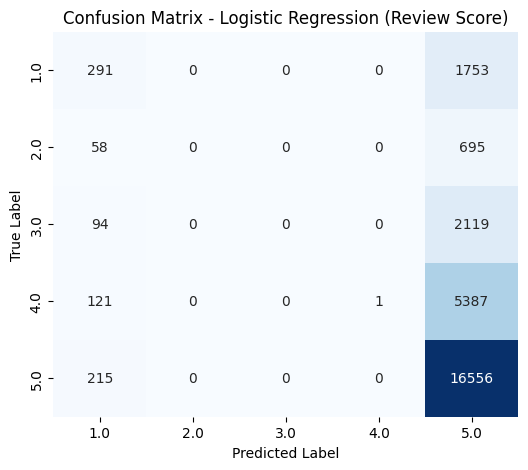

In [79]:
from sklearn.linear_model import LogisticRegression

log_reg_intermediate_review = LogisticRegression(
    random_state=42,
    C=0.5,
    solver='liblinear',
    penalty='l2',
    max_iter=2000
)

log_reg_intermediate_review.fit(X_review_train, Y_review_train)

Y_pred_intermediate_review_log_reg = log_reg_intermediate_review.predict(X_review_test)
Y_pred_proba_intermediate_review_log_reg = log_reg_intermediate_review.predict_proba(X_review_test)


print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_log_reg,
    model_name='Logistic Regression (Review Score)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_log_reg,
    model_name='Logistic Regression (Review Score)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_intermediate_review_log_reg))))
)


Este modelo presenta un F1-Macro similar al anterior, sin embargo destaca en algunas de las demás métricas. Sigue sin predecir valores entre 1 y 5, por lo cuál vamos a realizar un Gridsearch para buscar parámetros más óptimos con validación cruzada.

**Modelo con Validacion Cruzada**

Best parameters found by Grid Search: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}

--- Metrics for Logistic Regression Grid Search Best (Review Score) ---
Accuracy: 0.6172957127152803
Precision: 0.4118030736823517
Recall: 0.6172957127152803
F1-Score: 0.48575782486586344

Classification Report:
              precision    recall  f1-score   support

         1.0       0.37      0.14      0.21      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       0.00      0.00      0.00      5509
         5.0       0.62      0.99      0.76     16771

    accuracy                           0.62     27290
   macro avg       0.20      0.23      0.19     27290
weighted avg       0.41      0.62      0.49     27290

-----------------------------------------------------------------------


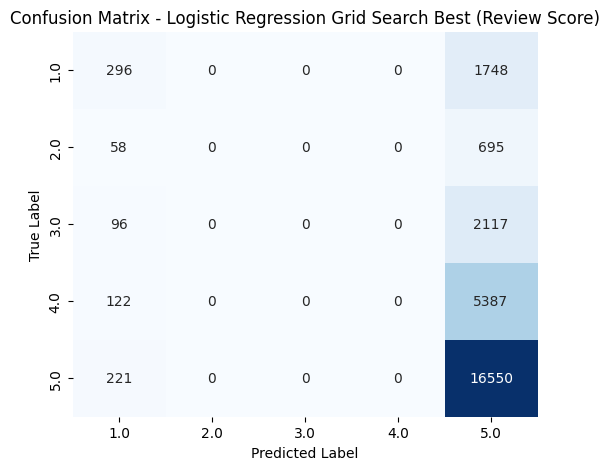

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

log_reg = LogisticRegression(random_state=42)

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_log_reg = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_log_reg.fit(X_review_train, Y_review_train)

best_params_log_reg = grid_search_log_reg.best_params_
best_log_reg_model = grid_search_log_reg.best_estimator_

print("Best parameters found by Grid Search:", best_params_log_reg)

Y_pred_best_log_reg = best_log_reg_model.predict(X_review_test)
Y_pred_proba_best_log_reg = best_log_reg_model.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_log_reg,
    model_name='Logistic Regression Grid Search Best (Review Score)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_log_reg,
    model_name='Logistic Regression Grid Search Best (Review Score)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_best_log_reg))))
)


Este modelo parece seguir teniendo los mismos problemas que los anteriores, lo que nos lleva a las dos posibles conclusiones a continuación:

- El modelo de clasificación por medio de regresión logística no se ve afectado por sus parámetros
- No exploramos una variedad alta de parámetros

**Análisis Comparativo**

Los resultados entre la variación de parámetros manual y el ajuste utilizando validación cruzada son similares, se presenta un problema similar al encontrado intentando predecir utilizando regresiones. La prevalencia de valores de 5 estrellas hace difícil que el modelo aprenda sobre los valores menos representados.

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for Logistic Regression Baseline (Satisfaction) ---
Accuracy: 0.8204470502015391
Precision: 0.7802329774311547
Recall: 0.8204470502015391
F1-Score: 0.764233362140326

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.10      0.16      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.70      0.54      0.53     27290
weighted avg       0.78      0.82      0.76     27290

---------------------------------------------------------------


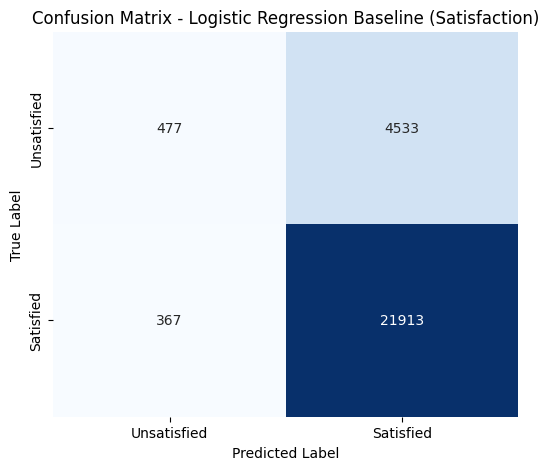

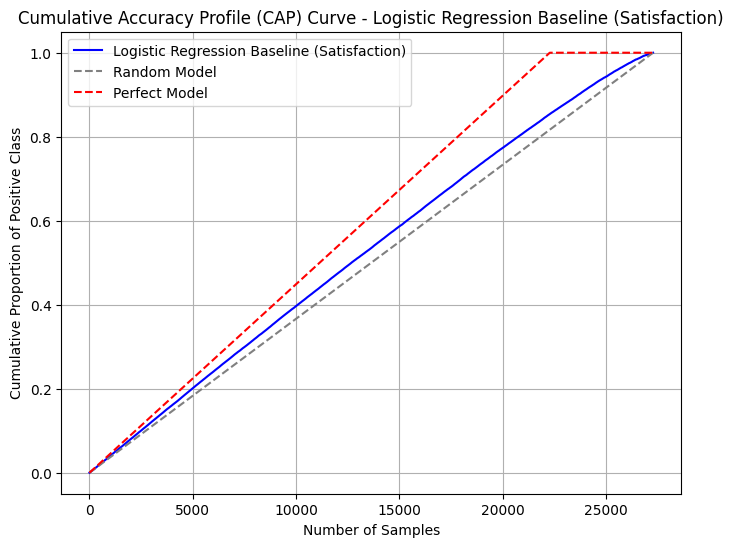

In [111]:
from sklearn.linear_model import LogisticRegression

log_reg_baseline_satisfaction = LogisticRegression(
    random_state=42,
    C=10,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)

log_reg_baseline_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_baseline_satisfaction_log_reg = log_reg_baseline_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_baseline_satisfaction_log_reg = log_reg_baseline_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_log_reg,
    model_name='Logistic Regression Baseline (Satisfaction)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_log_reg,
    model_name='Logistic Regression Baseline (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_baseline_satisfaction_log_reg,
    model_name='Logistic Regression Baseline (Satisfaction)'
)


Este modelo inicial tuvo un desempeño muy bueno en cuánto a órdenes que llegaron a tiempo, sin embargo una gran parte de las que llegaron tarde fueron clasificadas erróneamente. Según las estadísticas clave como F1, el modelo tuvo un desempeño aceptable. Sin embargo, observando la cuva CAP encontramos que el modelo está más cercano a una curva de un modelo aleatorio que la de un modelo perfecto.

**Modelo con Parametros Modificados**


--- Metrics for Logistic Regression Intermediate (Satisfaction - BETTER) ---
Accuracy: 0.8205936240381092
Precision: 0.7807389108123591
Recall: 0.8205936240381092
F1-Score: 0.7643767171761873

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.10      0.16      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.70      0.54      0.53     27290
weighted avg       0.78      0.82      0.76     27290

----------------------------------------------------------------------------


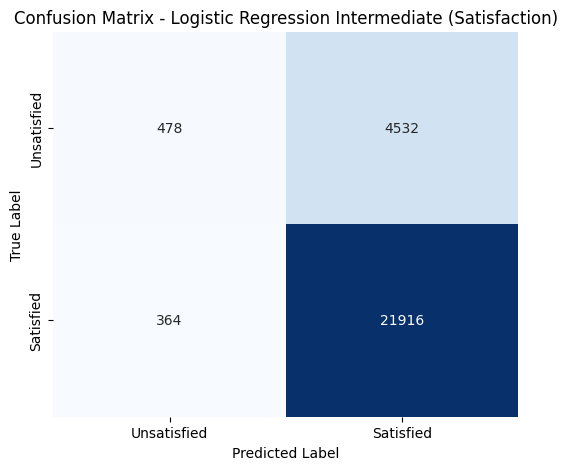

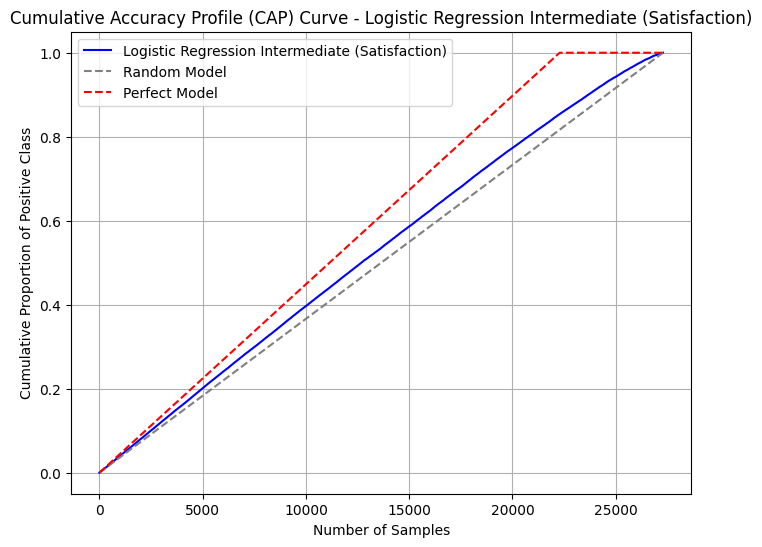

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_intermediate_satisfaction = LogisticRegression(
    random_state=42,
    C=0.5,
    solver='liblinear',
    penalty='l2',
    max_iter=2000
)

log_reg_intermediate_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_intermediate_satisfaction_log_reg = log_reg_intermediate_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_intermediate_satisfaction_log_reg = log_reg_intermediate_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_intermediate_satisfaction_log_reg,
    model_name='Logistic Regression Intermediate (Satisfaction)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_intermediate_satisfaction_log_reg,
    model_name='Logistic Regression Intermediate (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_intermediate_satisfaction_log_reg,
    model_name='Logistic Regression Intermediate (Satisfaction)'
)

A pesar de haber variado los parámetros, el modelo es casi idéntico al modelo anterior. Podemos asumir que hay algún trend o información que el modelo no es capaz de captar todavía, por lo que puede requerir utilizar validación cruzada.

Best parameters found by Grid Search (scored by F1-macro): {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

--- Metrics for Logistic Regression Grid Search Best (Satisfaction) ---
Accuracy: 0.8204836936606815
Precision: 0.7803211306540949
Recall: 0.8204836936606815
F1-Score: 0.7645021503275169

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.10      0.16      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.70      0.54      0.53     27290
weighted avg       0.78      0.82      0.76     27290

-----------------------------------------------------------------------


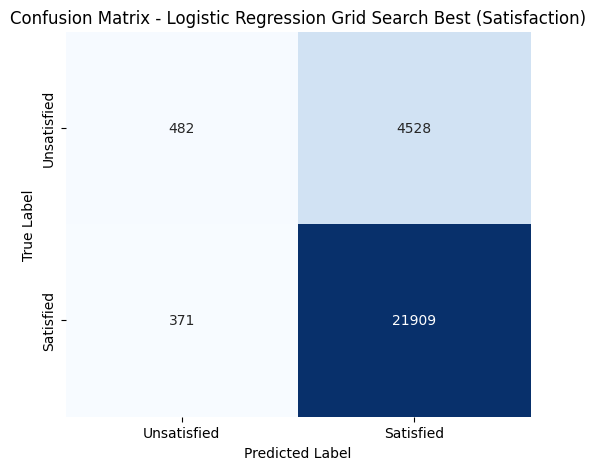

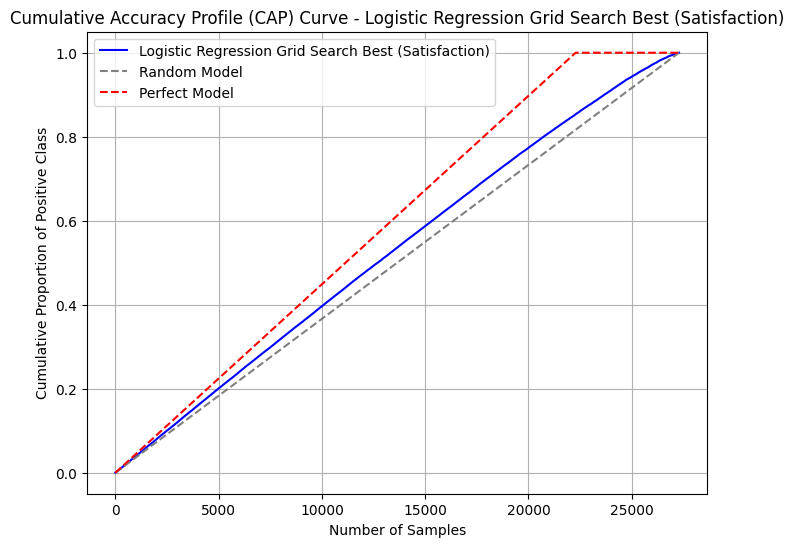

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

log_reg = LogisticRegression(random_state=42)

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_log_reg_satisfaction = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_log_reg_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

best_params_log_reg_satisfaction = grid_search_log_reg_satisfaction.best_params_
best_log_reg_model_satisfaction = grid_search_log_reg_satisfaction.best_estimator_

print("Best parameters found by Grid Search (scored by F1-macro):", best_params_log_reg_satisfaction)

Y_pred_best_log_reg_satisfaction = best_log_reg_model_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_log_reg_satisfaction = best_log_reg_model_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_log_reg_satisfaction,
    model_name='Logistic Regression Grid Search Best (Satisfaction)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_log_reg_satisfaction,
    model_name='Logistic Regression Grid Search Best (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_log_reg_satisfaction,
    model_name='Logistic Regression Grid Search Best (Satisfaction)'
)


El modelo sigue haciendo predicciones muy similares, por lo que podemos concluir que la variación de parámetros e implementación de validación cruzada no fue efectiva.

**Análisis Comparativo**

Ambos modelos utilizando variación de parámetros al igual que validación cruzada tuvieron un desempeño pobre, esto nos lleva a teorizar que este modelo no es capaz de reconocer las relaciones detrás de los datos. Al no tener mejora alguna, puede que no hayamos explorado un espacio parametral suficientemente alto o que el modelo simplemente no se adapte a los datos.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for Logistic Regression Baseline (Delivery Delayed) ---
Accuracy: 0.9632832539391719
Precision: 0.9427214023385337
Recall: 0.9632832539391719
F1-Score: 0.9454486721951388

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.40      0.00      0.00      1001

    accuracy                           0.96     27290
   macro avg       0.68      0.50      0.49     27290
weighted avg       0.94      0.96      0.95     27290

-------------------------------------------------------------------


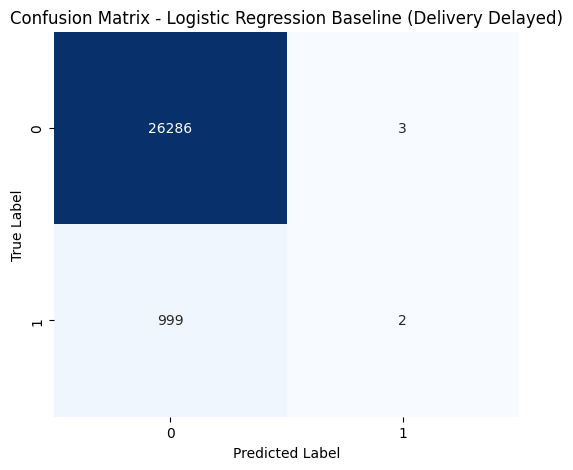

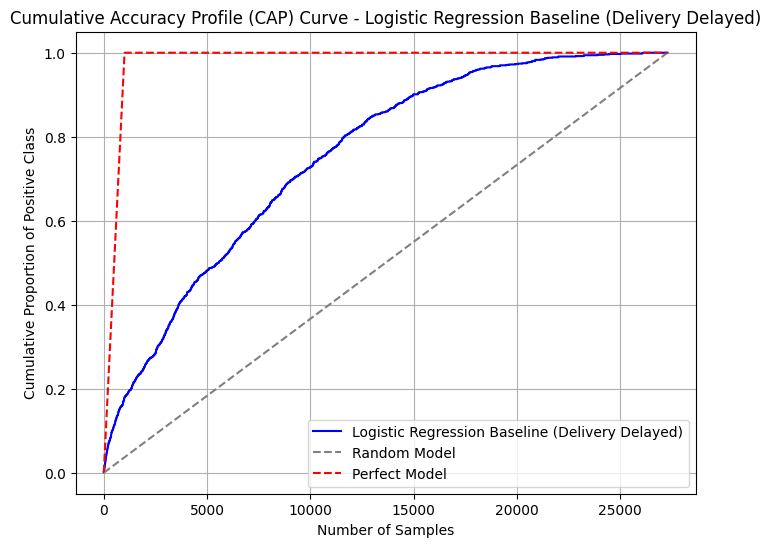

In [84]:
from sklearn.linear_model import LogisticRegression

log_reg_baseline_delayed = LogisticRegression(
    random_state=42,
    C=10,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)

log_reg_baseline_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_baseline_delayed_log_reg = log_reg_baseline_delayed.predict(X_delayed_test)

Y_pred_proba_baseline_delayed_log_reg = log_reg_baseline_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_log_reg,
    model_name='Logistic Regression Baseline (Delivery Delayed)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_log_reg,
    model_name='Logistic Regression Baseline (Delivery Delayed)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_baseline_delayed_log_reg))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_baseline_delayed_log_reg,
    model_name='Logistic Regression Baseline (Delivery Delayed)'
)


Este modelo parece tener estadísticas altas en cuánto a Weighted, sin embargo las estadísticas Macro indican un mal rendimiento. Observando la curva CAP, el modelo está por encima del punto medio entre las curvas aleatorias y perfectas. Estos resultados no son estelares, pero por otro lado podemos intentar variar los parámetros para obtener resultados más precisos.

**Modelo con Parametros Modificados**


--- Metrics for Logistic Regression Intermediate (Delivery Delayed) ---
Accuracy: 0.9632832539391719
Precision: 0.9427214023385337
Recall: 0.9632832539391719
F1-Score: 0.9454486721951388

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.40      0.00      0.00      1001

    accuracy                           0.96     27290
   macro avg       0.68      0.50      0.49     27290
weighted avg       0.94      0.96      0.95     27290

-----------------------------------------------------------------------


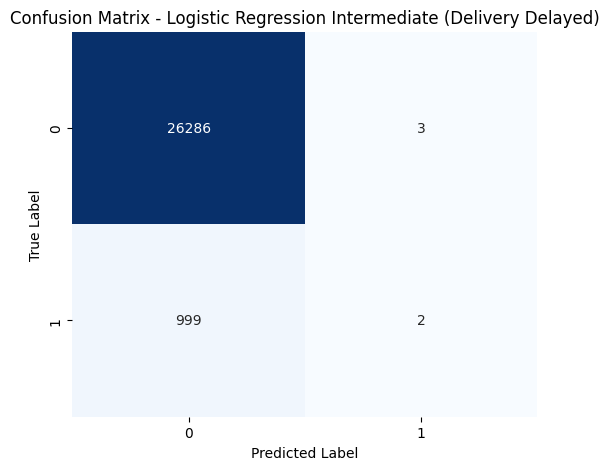

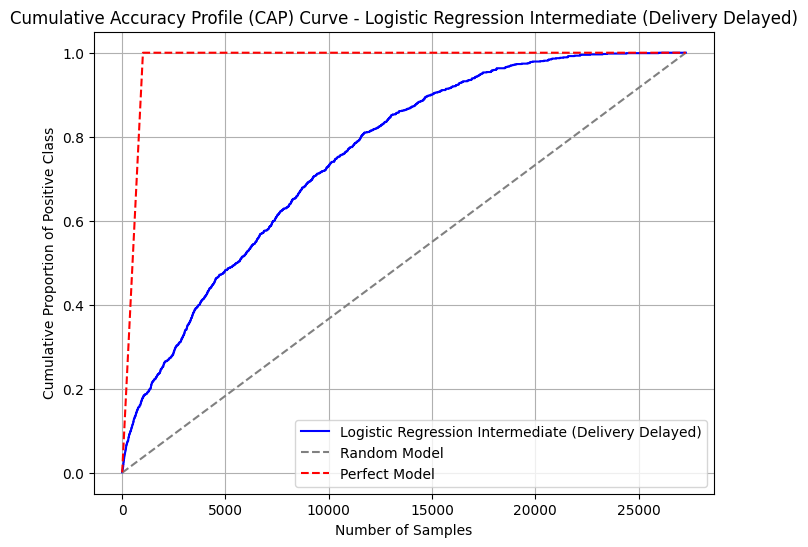

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_intermediate_delayed = LogisticRegression(
    random_state=42,
    C=0.5,
    solver='liblinear',
    penalty='l2',
    max_iter=2000
)

log_reg_intermediate_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_intermediate_delayed_log_reg = log_reg_intermediate_delayed.predict(X_delayed_test)

Y_pred_proba_intermediate_delayed_log_reg = log_reg_intermediate_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_intermediate_delayed_log_reg,
    model_name='Logistic Regression Intermediate (Delivery Delayed)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_intermediate_delayed_log_reg,
    model_name='Logistic Regression Intermediate (Delivery Delayed)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_intermediate_delayed_log_reg))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_intermediate_delayed_log_reg,
    model_name='Logistic Regression Intermediate (Delivery Delayed)'
)

A pesar de incluir parámetros diferentes, las predicciones fueron prácticamente las mismas. Esto nos inclina más hacia poder acertar que el modelo no es el adecuado para los datos. Sin embargo, podemos seguir explorando utilizando Grid Search y validación cruzada.

**Modelo con Validacion Cruzada**

Best parameters found by Grid Search (scored by F1-macro): {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

--- Metrics for Logistic Regression Grid Search Best (Delivery Delayed) ---
Accuracy: 0.9633198973983144
Precision: 0.9463907052226155
Recall: 0.9633198973983144
F1-Score: 0.9454671343838087

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.50      0.00      0.00      1001

    accuracy                           0.96     27290
   macro avg       0.73      0.50      0.49     27290
weighted avg       0.95      0.96      0.95     27290

---------------------------------------------------------------------------


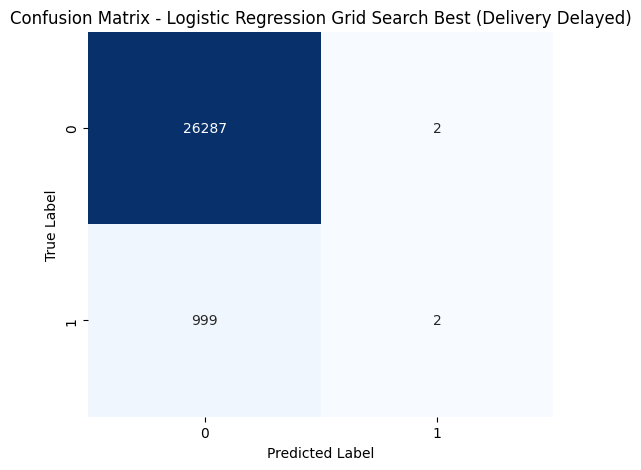

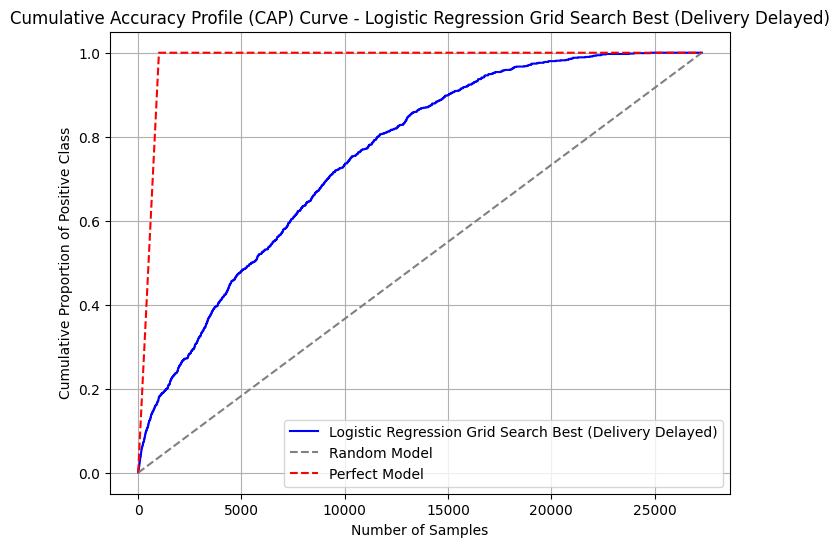

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

log_reg = LogisticRegression(random_state=42)

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_log_reg_delayed = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_log_reg_delayed.fit(X_delayed_train, Y_delayed_train)

best_params_log_reg_delayed = grid_search_log_reg_delayed.best_params_
best_log_reg_model_delayed = grid_search_log_reg_delayed.best_estimator_

print("Best parameters found by Grid Search (scored by F1-macro):", best_params_log_reg_delayed)

Y_pred_best_log_reg_delayed = best_log_reg_model_delayed.predict(X_delayed_test)
Y_pred_proba_best_log_reg_delayed = best_log_reg_model_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_log_reg_delayed,
    model_name='Logistic Regression Grid Search Best (Delivery Delayed)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_log_reg_delayed,
    model_name='Logistic Regression Grid Search Best (Delivery Delayed)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_best_log_reg_delayed))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_log_reg_delayed,
    model_name='Logistic Regression Grid Search Best (Delivery Delayed)'
)

Al observar los resultados, son principalmente idénticos a los modelos anteriores. Por lo que podemos asumir que este modelo no es el adecuado para los datos, la validación cruzada no nos ayudó a encontrar parámetros óptimos.

**Análisis Comparativo**

Los resultados son casi idénticos, y tomando en cuenta los resultados de las clasificaciones anteriores, la variación de parámetros y validación cruzada utilizando este modelo es poco efectiva. Es muy probable que se encuentren resultados similares utilizando los parámetros por defecto en comparación a realizar búsqueda a mayor profundidad o espacio parametral.

## Random Forest

### Review Score

**Modelo Baseline**


--- Metrics for Random Forest Baseline (Review Score - max_depth=3) ---
Accuracy: 0.6145474532795896
Precision: 0.3776685723324294
Recall: 0.6145474532795896
F1-Score: 0.46783211179737166

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       0.00      0.00      0.00      5509
         5.0       0.61      1.00      0.76     16771

    accuracy                           0.61     27290
   macro avg       0.12      0.20      0.15     27290
weighted avg       0.38      0.61      0.47     27290

-----------------------------------------------------------------------


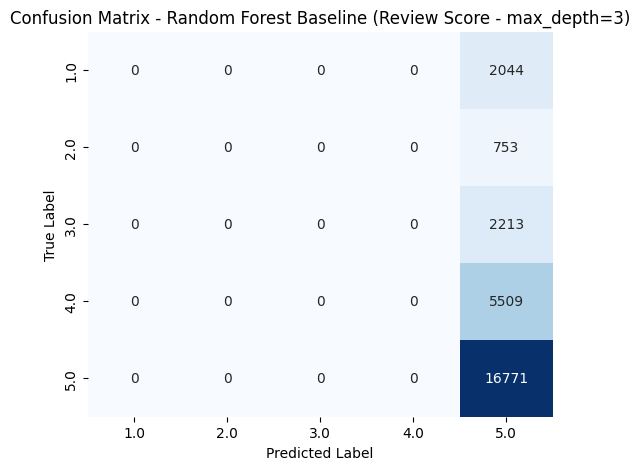

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf_baseline_review = RandomForestClassifier(random_state=42, max_depth=3)

rf_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review_rf = rf_baseline_review.predict(X_review_test)

Y_pred_proba_baseline_review_rf = rf_baseline_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_rf,
    model_name='Random Forest Baseline (Review Score - max_depth=3)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_rf,
    model_name='Random Forest Baseline (Review Score - max_depth=3)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_baseline_review_rf))))
)


Este modelo inicial de Random Forest tuvo un desempeño sumamente pobre, prediciendo únicamente 5 estrellas para todos. Esto nos indica que no fue capaz de captar ninguna correlación entre las variables de entrada. Esto puede darse debido a parámetros como max_depth insuficiente, por lo que debemos variar estos parámetros en busca de un mejor modelo utilizando Random Forest.

**Modelo con Parametros Modificados**


--- Metrics for Random Forest Intermediate (Review Score - max_depth=10, n_estimators=200) ---
Accuracy: 0.6210333455478197
Precision: 0.4219584725522163
Recall: 0.6210333455478197
F1-Score: 0.48648608314654995

Classification Report:
              precision    recall  f1-score   support

         1.0       0.52      0.13      0.21      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       0.00      0.00      0.00      5509
         5.0       0.62      0.99      0.77     16771

    accuracy                           0.62     27290
   macro avg       0.23      0.23      0.20     27290
weighted avg       0.42      0.62      0.49     27290

----------------------------------------------------------------------------------------------


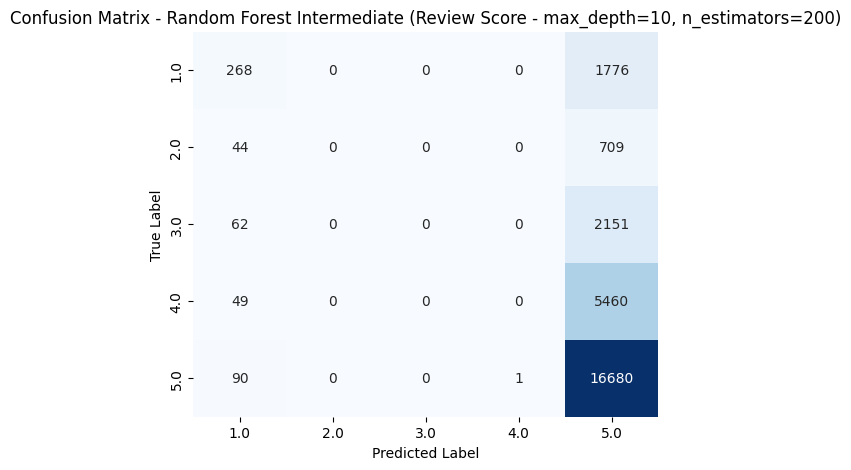

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf_intermediate_review = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)

rf_intermediate_review.fit(X_review_train, Y_review_train)

Y_pred_intermediate_review_rf = rf_intermediate_review.predict(X_review_test)

Y_pred_proba_intermediate_review_rf = rf_intermediate_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_rf,
    model_name='Random Forest Intermediate (Review Score - max_depth=10, n_estimators=200)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_rf,
    model_name='Random Forest Intermediate (Review Score - max_depth=10, n_estimators=200)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_intermediate_review_rf))))
)

Ya con los parámetros modificados de Max Depth y N Estimators, obtuvimos un mejor resultado. El modelo ya está teniendo predicciones correctas para valores de 1 y está variando un poco más. Sin embargo, seguimos teniendo dificultades para identificar valores intermedios.

**Modelo con Gridsearch y CV**

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found by Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Metrics for Random Forest Grid Search Best (Review Score - F1-macro) ---
Accuracy: 0.614034444851594
Precision: 0.49522340971288575
Recall: 0.614034444851594
F1-Score: 0.49932881810976615

Classification Report:
              precision    recall  f1-score   support

         1.0       0.47      0.15      0.23      2044
         2.0       0.10      0.00      0.01       753
         3.0       0.17      0.01      0.01      2213
         4.0       0.28      0.03      0.06      5509
         5.0       0.63      0.97      0.76     16771

    accuracy                           0.61     27290
   macro avg       0.33      0.23      0.21     27290
weighted avg       0.50      0.61      0.50     27290

----------------------------------------------------------------------------


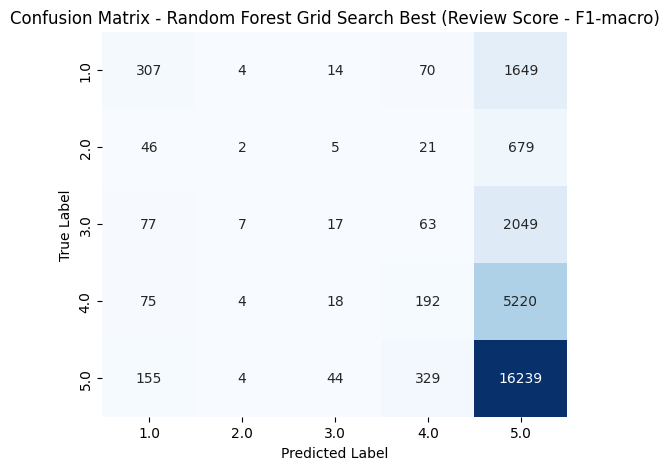

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_review = RandomForestClassifier(random_state=42)

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_rf_review = GridSearchCV(
    rf_review,
    param_grid,
    cv=4,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_rf_review.fit(X_review_train, Y_review_train)

best_params_rf_review = grid_search_rf_review.best_params_
best_rf_model_review = grid_search_rf_review.best_estimator_

print("Best parameters found by Grid Search:", best_params_rf_review)

Y_pred_best_rf_review = best_rf_model_review.predict(X_review_test)
Y_pred_proba_best_rf_review = best_rf_model_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_rf_review,
    model_name='Random Forest Grid Search Best (Review Score - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_rf_review,
    model_name='Random Forest Grid Search Best (Review Score - F1-macro)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_best_rf_review))))
)


Observando la matriz de confusión, nos podemos dar cuenta que es el modelo más apto hasta el momento. Los demás modelos probados únicamente hacían predicciones de 1 o 5 estrellas, sin embargo aquí ya podemos observar predicciones correctas a lo largo de la diagonal de la matriz. Sigue teniendo problemas debido al tamaño de la muestra de reviews con puntaje de 5, pero obtuvo un Macro F1 de 0.21, el cuál es el más alto hasta el momento

**Análisis Comparativo**

La implementación de validación cruzada utilizando Random Forest fue un éxito, el modelo muestra capacidad de realizar predicciones más variadas y más precisas al anterior. Sin embargo, también vale la pena recalcar que la variación de parámetros inicial también tuvo éxito.

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for Random Forest Baseline (Satisfaction - max_depth=3) ---
Accuracy: 0.8164162696958593
Precision: 0.6665355254241021
Recall: 0.8164162696958593
F1-Score: 0.7339017344693866

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5010
           1       0.82      1.00      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.41      0.50      0.45     27290
weighted avg       0.67      0.82      0.73     27290

-----------------------------------------------------------------------


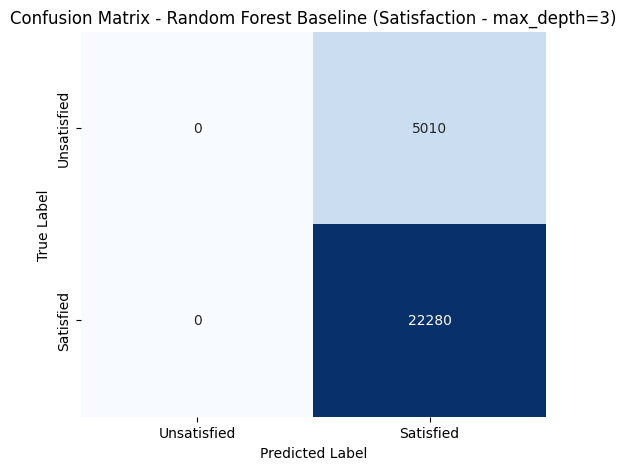

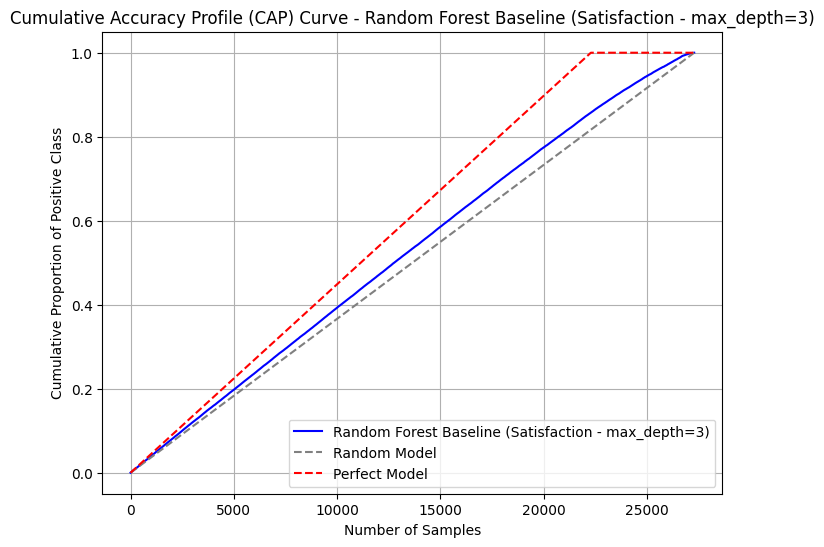

In [90]:
from sklearn.ensemble import RandomForestClassifier

rf_baseline_satisfaction = RandomForestClassifier(random_state=42, max_depth=3)

rf_baseline_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_baseline_satisfaction_rf = rf_baseline_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_baseline_satisfaction_rf = rf_baseline_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_rf,
    model_name='Random Forest Baseline (Satisfaction - max_depth=3)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_rf,
    model_name='Random Forest Baseline (Satisfaction - max_depth=3)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_baseline_satisfaction_rf,
    model_name='Random Forest Baseline (Satisfaction - max_depth=3)'
)


Al igual que el inciso anterior, el Random Forest con parámetros iniciales es completamente incapaz de realizar predicciones. Por lo que vamos a proceder a modificar los parámetros

**Modelo con Parametros Modificados**


--- Metrics for Random Forest Intermediate (Satisfaction - max_depth=10, n_estimators=200) ---
Accuracy: 0.8250274825943569
Precision: 0.8075295519731653
Recall: 0.8250274825943569
F1-Score: 0.762353467539729

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.08      0.14      5010
           1       0.83      0.99      0.90     22280

    accuracy                           0.83     27290
   macro avg       0.77      0.53      0.52     27290
weighted avg       0.81      0.83      0.76     27290

----------------------------------------------------------------------------------------------


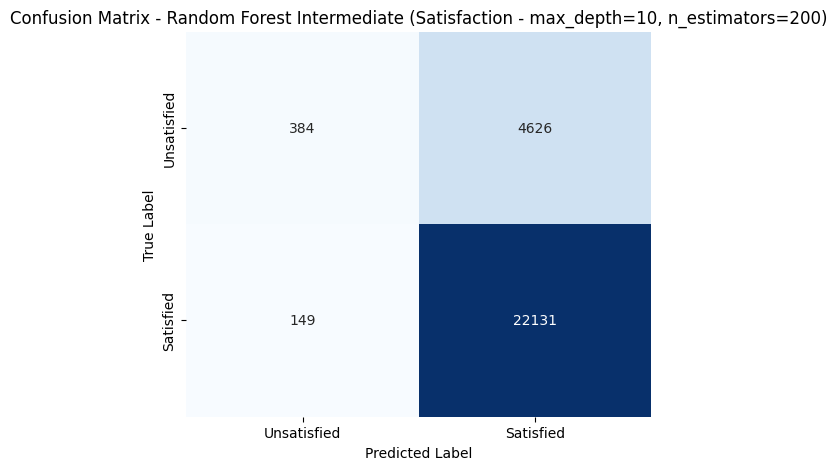

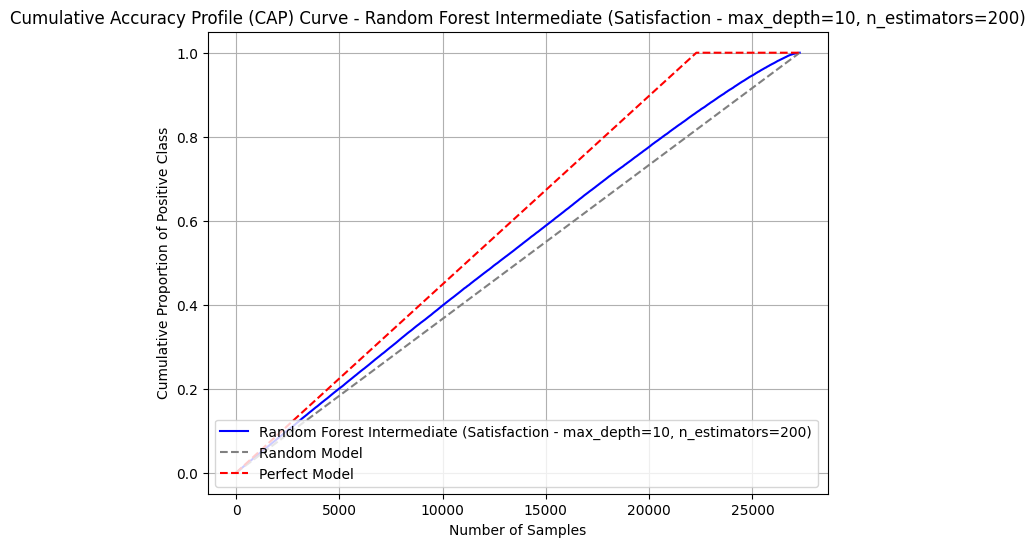

In [91]:
from sklearn.ensemble import RandomForestClassifier

rf_intermediate_satisfaction = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)

rf_intermediate_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_intermediate_satisfaction_rf = rf_intermediate_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_intermediate_satisfaction_rf = rf_intermediate_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_intermediate_satisfaction_rf,
    model_name='Random Forest Intermediate (Satisfaction - max_depth=10, n_estimators=200)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_intermediate_satisfaction_rf,
    model_name='Random Forest Intermediate (Satisfaction - max_depth=10, n_estimators=200)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_intermediate_satisfaction_rf,
    model_name='Random Forest Intermediate (Satisfaction - max_depth=10, n_estimators=200)'
)


Con los parámetros modificados, logramos tener una curva CAP más separada de la línea de un modelo aleatorio. Además, las predicciones ya son más variadas y presenta un Macro F1 más alto.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Metrics for Random Forest Grid Search Best (Satisfaction - F1-macro) ---
Accuracy: 0.8233052400146574
Precision: 0.7890076621871215
Recall: 0.8233052400146574
F1-Score: 0.7697982293099698

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.11      0.19      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.72      0.55      0.54     27290
weighted avg       0.79      0.82      0.77     27290

----------------------------------------------------------------------------


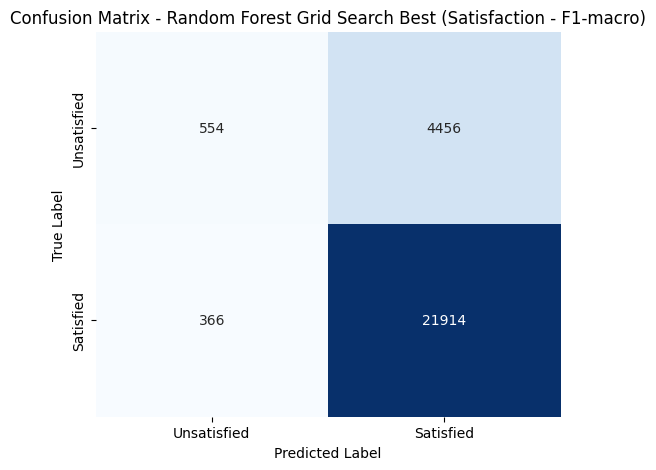

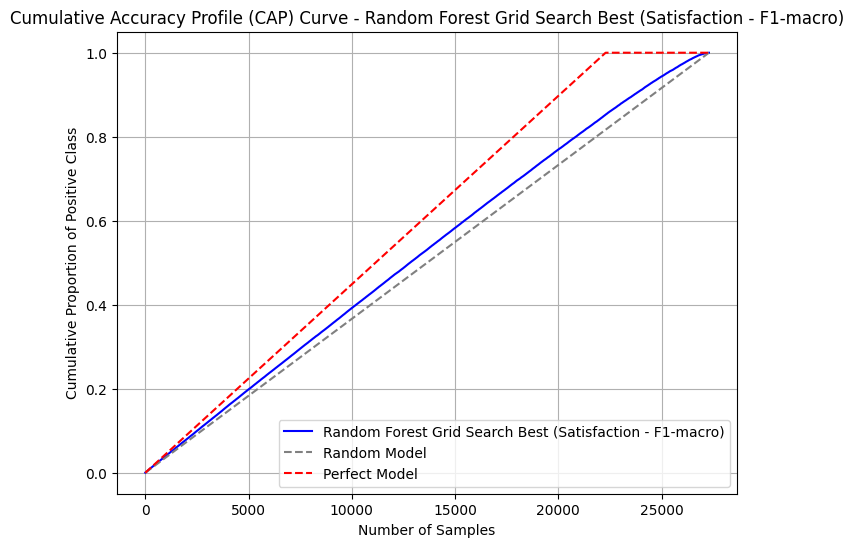

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_satisfaction = RandomForestClassifier(random_state=42)

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_rf_satisfaction = GridSearchCV(
    rf_satisfaction,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_rf_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

best_params_rf_satisfaction = grid_search_rf_satisfaction.best_params_
best_rf_model_satisfaction = grid_search_rf_satisfaction.best_estimator_

print("Best parameters found by Grid Search:", best_params_rf_satisfaction)

Y_pred_best_rf_satisfaction = best_rf_model_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_rf_satisfaction = best_rf_model_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_rf_satisfaction,
    model_name='Random Forest Grid Search Best (Satisfaction - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_rf_satisfaction,
    model_name='Random Forest Grid Search Best (Satisfaction - F1-macro)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_rf_satisfaction,
    model_name='Random Forest Grid Search Best (Satisfaction - F1-macro)'
)


Este modelo sigue primariamente prediciendo clientes satisfechos, sin embargo logró predecir de manera correcta los clientes no satisfechos con mayor frecuencia en comparación a no tener validación cruzada. Además, tuvo algunas ganancias en comparación a modelos anteriores.

**Análisis Comparativo**

El implementar validación cruzada para este modelo mejoró los números significativamente, sin embargo sigue sin poder hacer predicciones súmamente precisas. El caso fue idéntico al anterior, por lo que nos inclinamos a afirmar que la variación de parámetros utilizando Random Forest es sumamente valiosa.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for Random Forest Baseline (Delivery Delayed - max_depth=3) ---
Accuracy: 0.9633198973983144
Precision: 0.927985224723499
Recall: 0.9633198973983144
F1-Score: 0.9453224876427067

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.00      0.00      0.00      1001

    accuracy                           0.96     27290
   macro avg       0.48      0.50      0.49     27290
weighted avg       0.93      0.96      0.95     27290

---------------------------------------------------------------------------


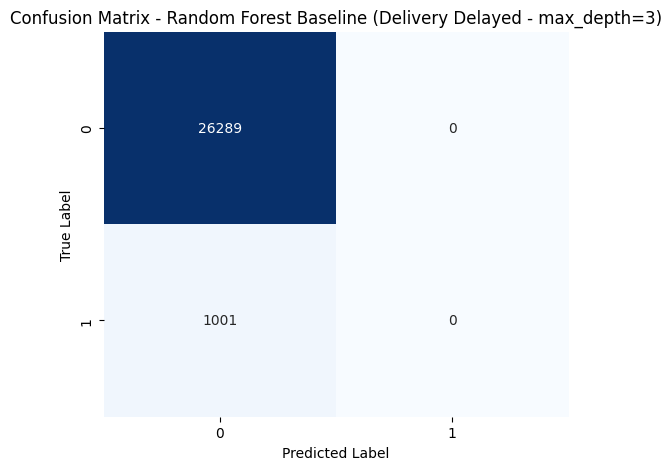

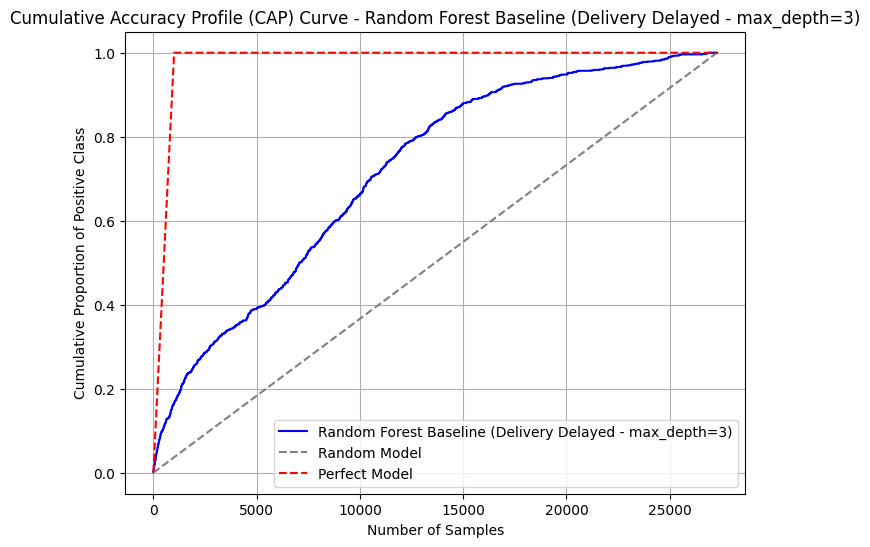

In [93]:
from sklearn.ensemble import RandomForestClassifier

rf_baseline_delayed = RandomForestClassifier(random_state=42, max_depth=3)

rf_baseline_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_baseline_delayed_rf = rf_baseline_delayed.predict(X_delayed_test)

Y_pred_proba_baseline_delayed_rf = rf_baseline_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_rf,
    model_name='Random Forest Baseline (Delivery Delayed - max_depth=3)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_rf,
    model_name='Random Forest Baseline (Delivery Delayed - max_depth=3)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_baseline_delayed_rf))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_baseline_delayed_rf,
    model_name='Random Forest Baseline (Delivery Delayed - max_depth=3)'
)


De manera similar a los incisos anteriores, este modelo es completamente incapaz de hacer predicciones. Devuelve el mismo valor para todos, así que no tiene valor alguno como modelo.

**Modelo con Parametros Modificados**


--- Metrics for Random Forest Intermediate (Delivery Delayed - max_depth=10, n_estimators=200) ---
Accuracy: 0.9633198973983144
Precision: 0.927985224723499
Recall: 0.9633198973983144
F1-Score: 0.9453224876427067

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.00      0.00      0.00      1001

    accuracy                           0.96     27290
   macro avg       0.48      0.50      0.49     27290
weighted avg       0.93      0.96      0.95     27290

--------------------------------------------------------------------------------------------------


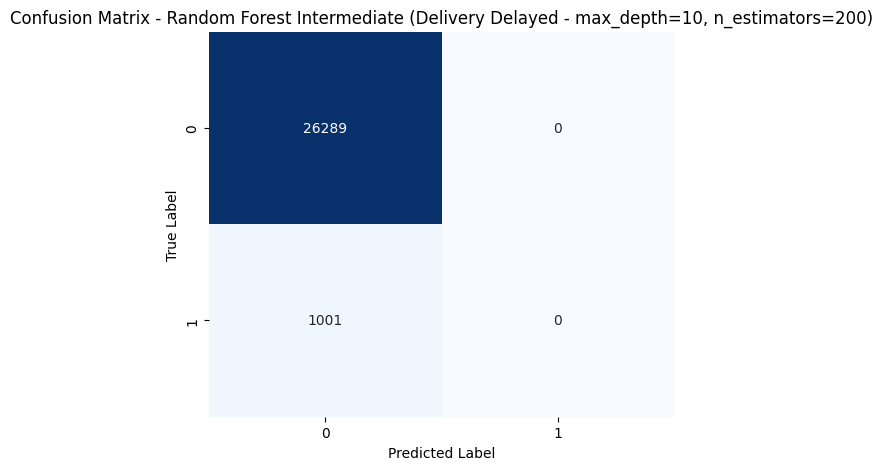

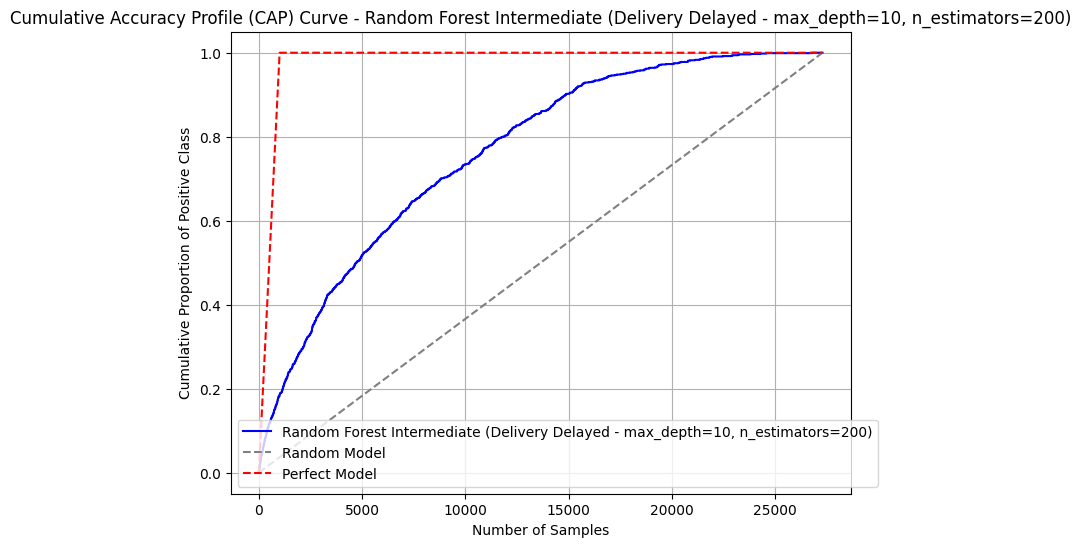

In [94]:
from sklearn.ensemble import RandomForestClassifier

rf_intermediate_delayed = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)

rf_intermediate_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_intermediate_delayed_rf = rf_intermediate_delayed.predict(X_delayed_test)

Y_pred_proba_intermediate_delayed_rf = rf_intermediate_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_intermediate_delayed_rf,
    model_name='Random Forest Intermediate (Delivery Delayed - max_depth=10, n_estimators=200)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_intermediate_delayed_rf,
    model_name='Random Forest Intermediate (Delivery Delayed - max_depth=10, n_estimators=200)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_intermediate_delayed_rf))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_intermediate_delayed_rf,
    model_name='Random Forest Intermediate (Delivery Delayed - max_depth=10, n_estimators=200)'
)


A pesar de haber variado los parámetros, este modelo sigue sufriendo de manera idéntica al anterior. Las predicciones son las mismas para todos los datos, por lo que podemos afirmar que no es capaz de detectar relación alguna.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Metrics for Random Forest Grid Search Best (Delivery Delayed - F1-macro) ---
Accuracy: 0.9628801758886039
Precision: 0.9415611033446678
Recall: 0.9628801758886039
F1-Score: 0.9461474826846568

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.36      0.01      0.03      1001

    accuracy                           0.96     27290
   macro avg       0.66      0.51      0.50     27290
weighted avg       0.94      0.96      0.95     27290

--------------------------------------------------------------------------------


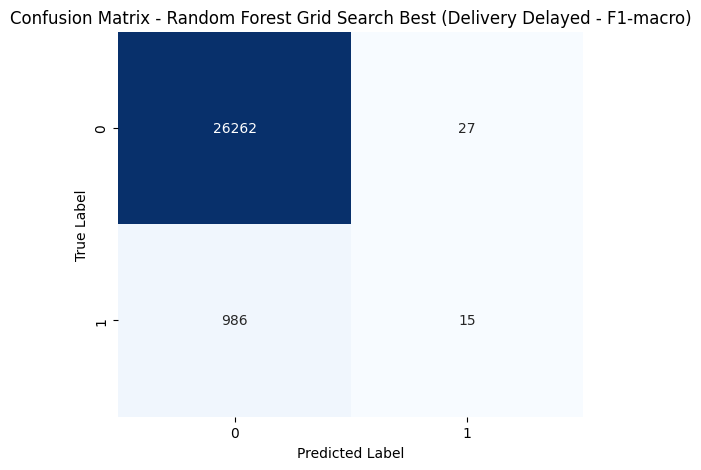

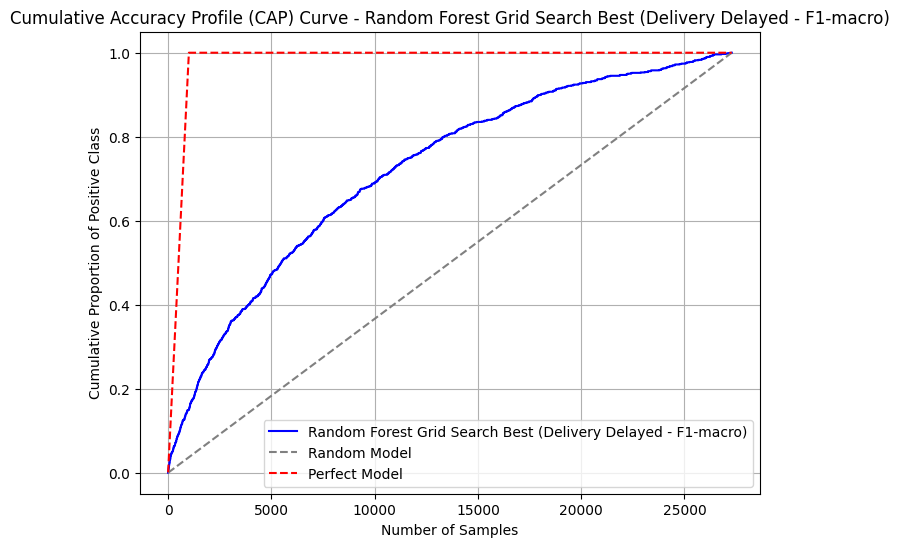

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_delayed = RandomForestClassifier(random_state=42)

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0) # Use macro for balanced class focus

grid_search_rf_delayed = GridSearchCV(
    rf_delayed,
    param_grid,
    cv=4, # Reduced CV folds for faster grid search
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_rf_delayed.fit(X_delayed_train, Y_delayed_train)

best_params_rf_delayed = grid_search_rf_delayed.best_params_
best_rf_model_delayed = grid_search_rf_delayed.best_estimator_

print("Best parameters found by Grid Search:", best_params_rf_delayed)

Y_pred_best_rf_delayed = best_rf_model_delayed.predict(X_delayed_test)
Y_pred_proba_best_rf_delayed = best_rf_model_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_rf_delayed,
    model_name='Random Forest Grid Search Best (Delivery Delayed - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_rf_delayed,
    model_name='Random Forest Grid Search Best (Delivery Delayed - F1-macro)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_best_rf_delayed))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_rf_delayed,
    model_name='Random Forest Grid Search Best (Delivery Delayed - F1-macro)'
)

Este modelo ya empieza a generar predicciones de deliveries que se atrasaron, por lo que es superior a los anteriores. Además, es el modelo más preciso hasta el momento según las métricas Macro y Weighed. Observando la curva CAP, se encuentra ligeramente por encima del punto medio entre la curva aleatoria y la perfecta.

**Análisis Comparativo**

La aplicación de validación cruzada fue el factor clave en obtener un modelo predictor, ya que los modelos anteriores fueron incapaces de realizar predicciones. Concluyendo sobre la validación cruzada en Random Forest, esta es crucial al momento de trabajar con este clasificador y siempre debe tomarse en cuenta.

## Naive Bayes

### Review Score

**Modelo Baseline**


--- Metrics for Gaussian Naive Bayes Baseline (Review Score) ---
Accuracy: 0.03913521436423598
Precision: 0.49093923622695257
Recall: 0.03913521436423598
F1-Score: 0.024642819132287927

Classification Report:
              precision    recall  f1-score   support

         1.0       0.16      0.02      0.04      2044
         2.0       0.03      0.96      0.05       753
         3.0       0.08      0.01      0.01      2213
         4.0       0.21      0.03      0.06      5509
         5.0       0.70      0.01      0.01     16771

    accuracy                           0.04     27290
   macro avg       0.23      0.20      0.03     27290
weighted avg       0.49      0.04      0.02     27290

----------------------------------------------------------------


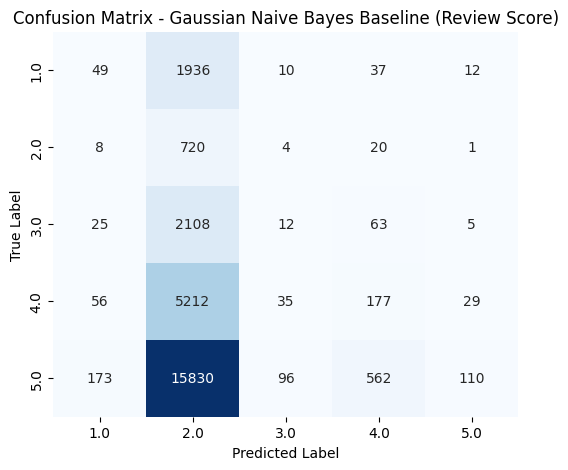

In [96]:
from sklearn.naive_bayes import GaussianNB

nb_baseline_review = GaussianNB()

nb_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review_nb = nb_baseline_review.predict(X_review_test)

Y_pred_proba_baseline_review_nb = nb_baseline_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_nb,
    model_name='Gaussian Naive Bayes Baseline (Review Score)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_nb,
    model_name='Gaussian Naive Bayes Baseline (Review Score)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_baseline_review_nb))))
)

El modelo baseline de NB nos dió resultados bastante peculiares, mientras los demás principalmente predecían valores altos, NB realizó predicciones sumamente variadas pero imprecisas a la vez. Esto nos puede servir de indicador para variar los parámetros y seguir explorando este modelo.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'var_smoothing': np.float64(0.005336699231206307)}

--- Metrics for Gaussian Naive Bayes Grid Search Best (Review Score - F1-macro) ---
Accuracy: 0.5401245877610846
Precision: 0.4697838762910186
Recall: 0.5401245877610846
F1-Score: 0.4887252127261452

Classification Report:
              precision    recall  f1-score   support

         1.0       0.22      0.27      0.25      2044
         2.0       0.04      0.03      0.03       753
         3.0       0.10      0.07      0.08      2213
         4.0       0.24      0.07      0.11      5509
         5.0       0.64      0.81      0.72     16771

    accuracy                           0.54     27290
   macro avg       0.25      0.25      0.24     27290
weighted avg       0.47      0.54      0.49     27290

-----------------------------------------------------------------------------------


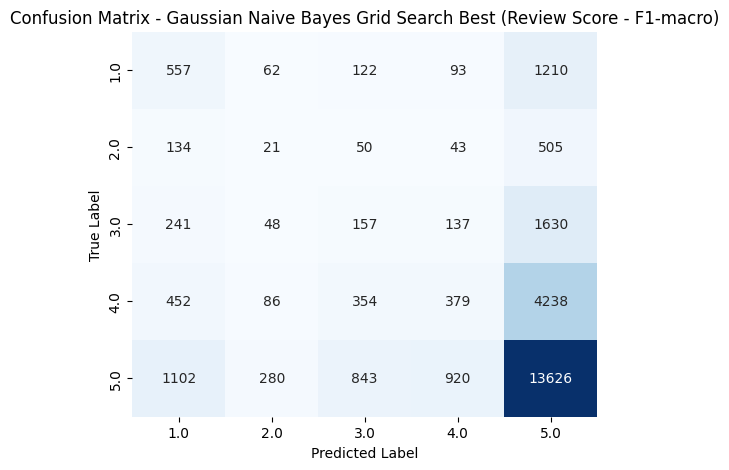

In [97]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

nb_review = GaussianNB()

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_nb_review = GridSearchCV(
    nb_review,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_nb_review.fit(X_review_train, Y_review_train)

best_params_nb_review = grid_search_nb_review.best_params_
best_nb_model_review = grid_search_nb_review.best_estimator_

print("Best parameters found by Grid Search:", best_params_nb_review)

Y_pred_best_nb_review = best_nb_model_review.predict(X_review_test)
Y_pred_proba_best_nb_review = best_nb_model_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_nb_review,
    model_name='Gaussian Naive Bayes Grid Search Best (Review Score - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_nb_review,
    model_name='Gaussian Naive Bayes Grid Search Best (Review Score - F1-macro)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_best_nb_review))))
)


Al realizar un Gridsearch, encontramos que NB realiza predicciones variadas pero imprecisas. En general, no parece haber aprendido mucho o haber captado de manera correcta las relaciones entre datos. Sin embargo, al cambiar parámetros definitivamente se encontró una mejora

**Análisis Comparativo**

La aplicación de validación cruzada definitivamente resultó en un modelo superior, sin embargo NB no se ajustó a este set de datos en específico. Otra posibilidad puede ser que no se haya buscado en un espacio parametral lo suficientemente amplio, sin embargo esto es poco probable.

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for Gaussian Naive Bayes Baseline (Satisfaction) ---
Accuracy: 0.71700256504214
Precision: 0.7453281534596008
Recall: 0.71700256504214
F1-Score: 0.7296016366326231

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.37      0.32      5010
           1       0.85      0.80      0.82     22280

    accuracy                           0.72     27290
   macro avg       0.57      0.58      0.57     27290
weighted avg       0.75      0.72      0.73     27290

----------------------------------------------------------------


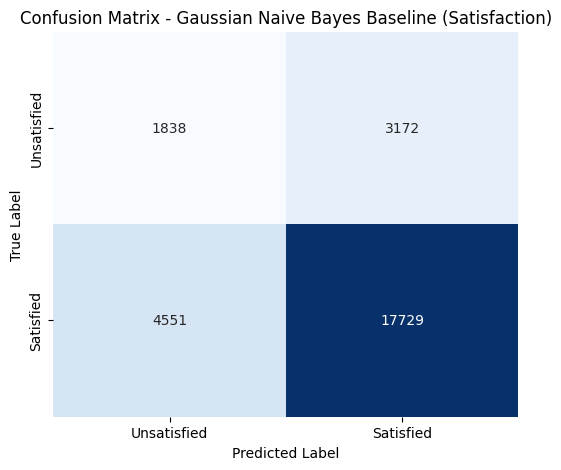

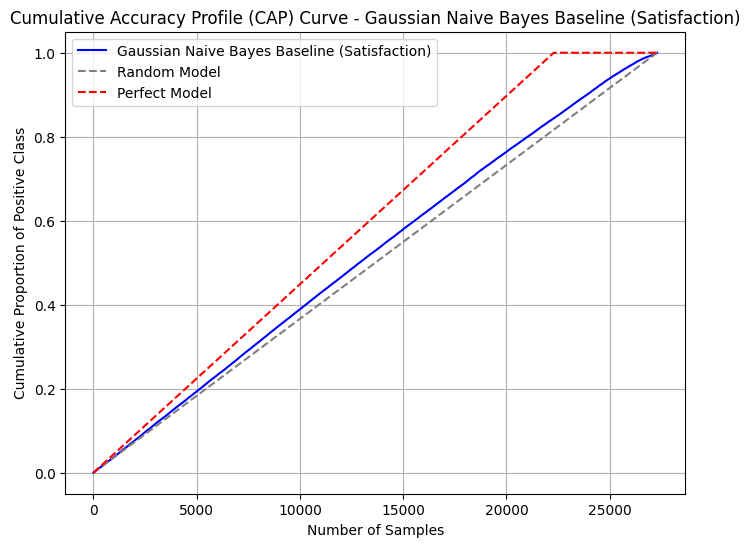

In [98]:
from sklearn.naive_bayes import GaussianNB

nb_baseline_satisfaction = GaussianNB()

nb_baseline_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_baseline_satisfaction_nb = nb_baseline_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_baseline_satisfaction_nb = nb_baseline_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_nb,
    model_name='Gaussian Naive Bayes Baseline (Satisfaction)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_nb,
    model_name='Gaussian Naive Bayes Baseline (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_baseline_satisfaction_nb,
    model_name='Gaussian Naive Bayes Baseline (Satisfaction)'
)

Este modelo parece tener un desempeño bastante alto, especialmente considerando que es el modelo baseline. A pesar de no tener una curva CAP ideal, el modelo tiene puntajes Macro comparables a las versiones finales de algunos modelos anteriores.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'var_smoothing': np.float64(0.005336699231206307)}

--- Metrics for Gaussian Naive Bayes Grid Search Best (Satisfaction - F1-macro) ---
Accuracy: 0.7853059728838402
Precision: 0.7533836678673642
Recall: 0.7853059728838402
F1-Score: 0.7654578623061449

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.23      0.28      5010
           1       0.84      0.91      0.87     22280

    accuracy                           0.79     27290
   macro avg       0.60      0.57      0.58     27290
weighted avg       0.75      0.79      0.77     27290

-----------------------------------------------------------------------------------


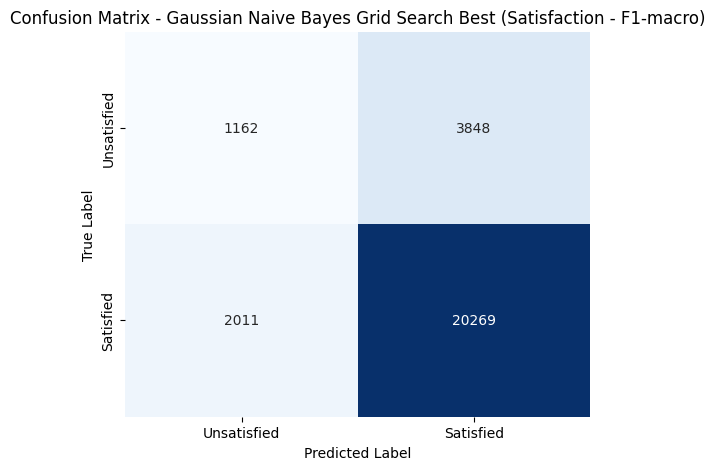

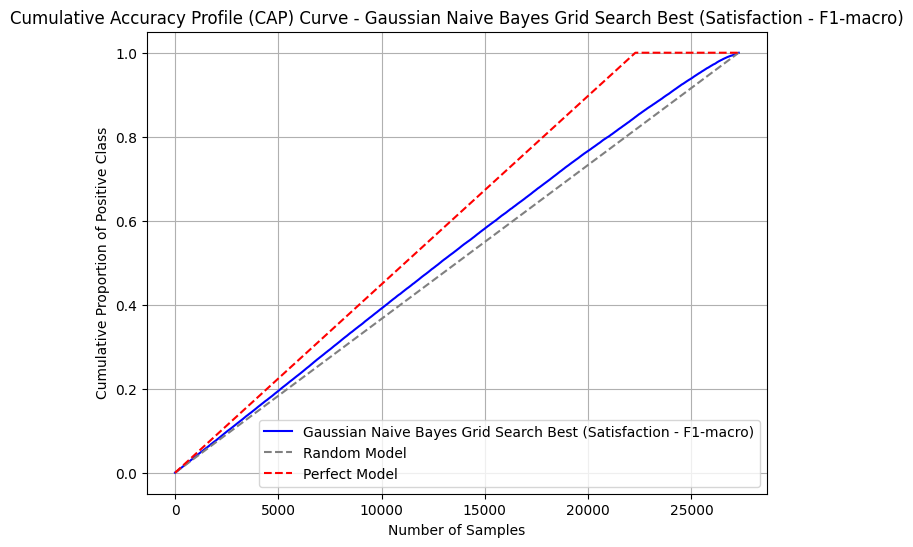

In [99]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

nb_satisfaction = GaussianNB()

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_nb_satisfaction = GridSearchCV(
    nb_satisfaction,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_nb_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

best_params_nb_satisfaction = grid_search_nb_satisfaction.best_params_
best_nb_model_satisfaction = grid_search_nb_satisfaction.best_estimator_

print("Best parameters found by Grid Search:", best_params_nb_satisfaction)

Y_pred_best_nb_satisfaction = best_nb_model_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_nb_satisfaction = best_nb_model_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_nb_satisfaction,
    model_name='Gaussian Naive Bayes Grid Search Best (Satisfaction - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_nb_satisfaction,
    model_name='Gaussian Naive Bayes Grid Search Best (Satisfaction - F1-macro)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_nb_satisfaction,
    model_name='Gaussian Naive Bayes Grid Search Best (Satisfaction - F1-macro)'
)

Luego de realizar un Gridsearch, el performance del modelo incrementó. Esto se puede observar en cada una de las métricas, sin embargo la curva CAP sigue similar. Para esta clasificación, Naive Bayes es el mejor modelo que hemos encontrado hasta el momento

**Análisis Comparativo**

Naive Bayes tuvo un alto rendimiento en ambas versiones, sin embargo encontramos valor al aplicar validación cruzada ya que obtuvimos mejores métricas Macro. Esto nos indica que a pesar de la distribución tan desigual, el modelo logró realizar predicciones para ambas categorías.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for Gaussian Naive Bayes Baseline (Delivery Delayed) ---
Accuracy: 0.07947966288017588
Precision: 0.9574036240256274
Recall: 0.07947966288017588
F1-Score: 0.08522008236125636

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.04      0.09     26289
           1       0.04      0.99      0.07      1001

    accuracy                           0.08     27290
   macro avg       0.52      0.52      0.08     27290
weighted avg       0.96      0.08      0.09     27290

--------------------------------------------------------------------


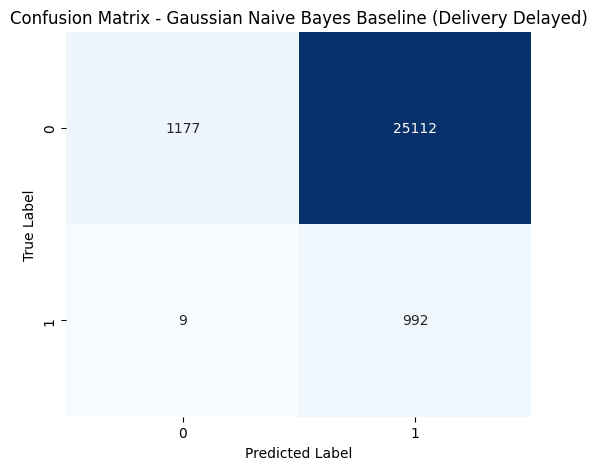

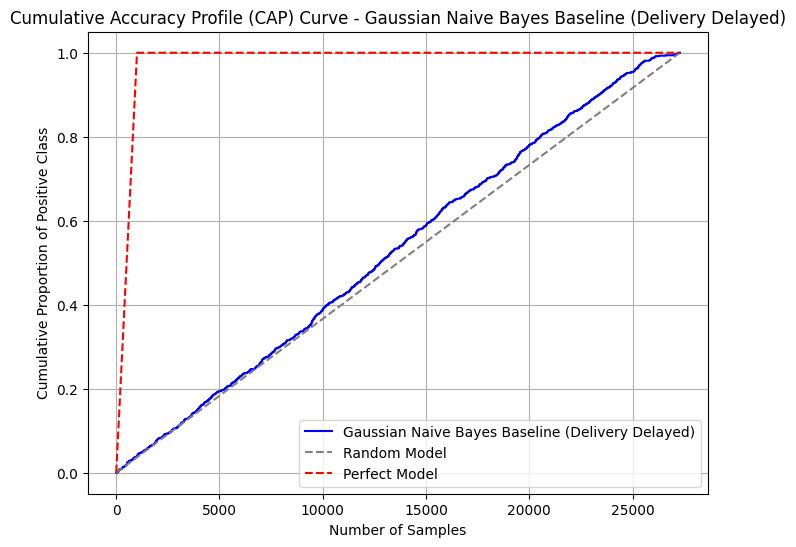

In [100]:
from sklearn.naive_bayes import GaussianNB

nb_baseline_delayed = GaussianNB()

nb_baseline_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_baseline_delayed_nb = nb_baseline_delayed.predict(X_delayed_test)

Y_pred_proba_baseline_delayed_nb = nb_baseline_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_nb,
    model_name='Gaussian Naive Bayes Baseline (Delivery Delayed)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_nb,
    model_name='Gaussian Naive Bayes Baseline (Delivery Delayed)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_baseline_delayed_nb))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_baseline_delayed_nb,
    model_name='Gaussian Naive Bayes Baseline (Delivery Delayed)'
)


Este modelo tuvo un rendimiento sumamente pobre, tomando en cuenta los incisos anteriores este es un resultado poco esperado. A lo largo del inicio de la gráfica, se mueve jsutamente con un modelo completamente aleatorio y no parece acercarse para nada a un modelo ideal.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'var_smoothing': np.float64(0.03511191734215131)}

--- Metrics for Gaussian Naive Bayes Grid Search Best (Delivery Delayed - F1-macro) ---
Accuracy: 0.9164162696958593
Precision: 0.9330616653864047
Recall: 0.9164162696958593
F1-Score: 0.9245041800104424

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     26289
           1       0.08      0.12      0.09      1001

    accuracy                           0.92     27290
   macro avg       0.52      0.53      0.52     27290
weighted avg       0.93      0.92      0.92     27290

---------------------------------------------------------------------------------------


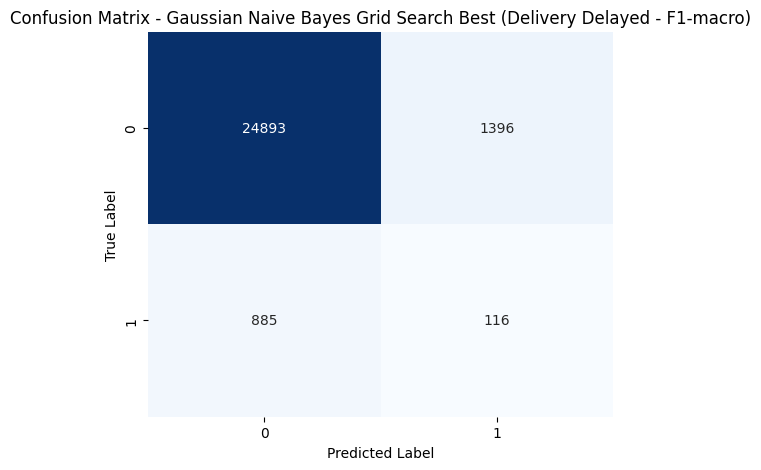

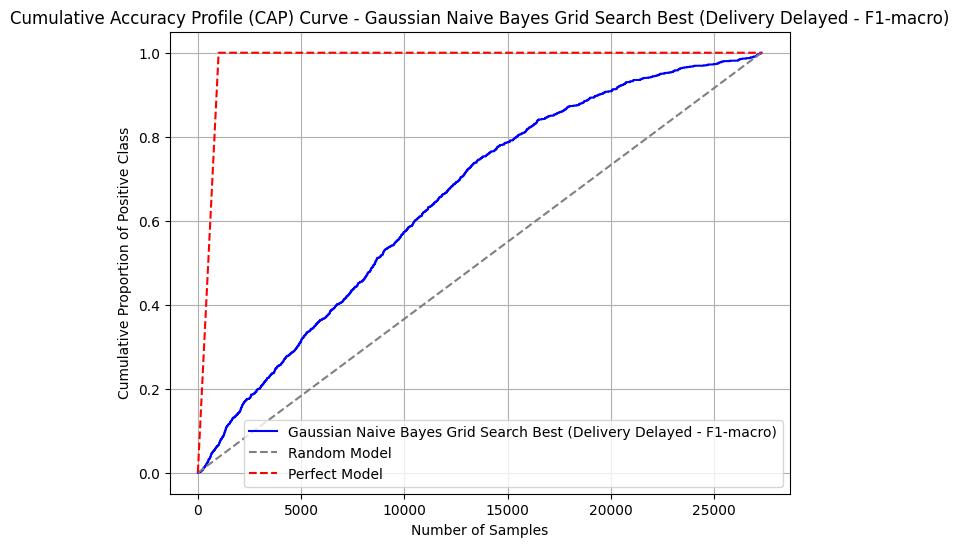

In [101]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

nb_delayed = GaussianNB()

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_nb_delayed = GridSearchCV(
    nb_delayed,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_nb_delayed.fit(X_delayed_train, Y_delayed_train)

best_params_nb_delayed = grid_search_nb_delayed.best_params_
best_nb_model_delayed = grid_search_nb_delayed.best_estimator_

print("Best parameters found by Grid Search:", best_params_nb_delayed)

Y_pred_best_nb_delayed = best_nb_model_delayed.predict(X_delayed_test)
Y_pred_proba_best_nb_delayed = best_nb_model_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_nb_delayed,
    model_name='Gaussian Naive Bayes Grid Search Best (Delivery Delayed - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_nb_delayed,
    model_name='Gaussian Naive Bayes Grid Search Best (Delivery Delayed - F1-macro)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_best_nb_delayed))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_nb_delayed,
    model_name='Gaussian Naive Bayes Grid Search Best (Delivery Delayed - F1-macro)'
)

Al implementar validación cruzada, podemos observar una diferencia clara de rendimiento entre los modelos dentro de la curva CAP. Este se distancia completamente de la curva del modelo aleatorio, y sus métricas son comparables a modelos anteriores.

**Análisis Comparativo**

Hay una diferencia claramente marcada, al implementar validación cruzada se fue de un rendimiento similar a un modelo aleatorio a un modelo que si puede realizar predicciones. Sin embargo, se sigue lejos de la curva ideal.

## KNN

### Review Score

**Modelo Baseline**


--- Metrics for KNN Baseline (Review Score - k=5) ---
Accuracy: 0.5245511176255039
Precision: 0.4632176554527314
Recall: 0.5245511176255039
F1-Score: 0.4880962951854406

Classification Report:
              precision    recall  f1-score   support

         1.0       0.24      0.18      0.21      2044
         2.0       0.05      0.01      0.02       753
         3.0       0.10      0.05      0.07      2213
         4.0       0.22      0.16      0.19      5509
         5.0       0.64      0.77      0.70     16771

    accuracy                           0.52     27290
   macro avg       0.25      0.24      0.24     27290
weighted avg       0.46      0.52      0.49     27290

-----------------------------------------------------


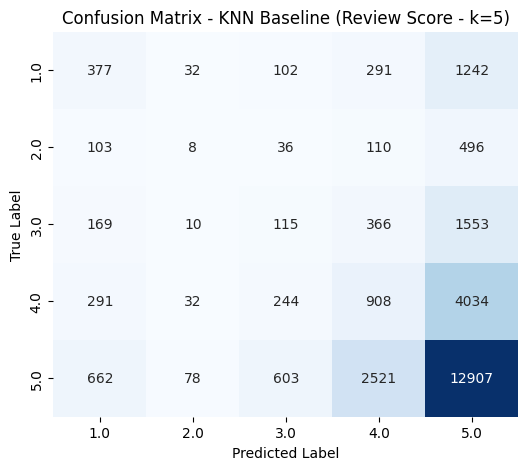

In [102]:
from sklearn.neighbors import KNeighborsClassifier

knn_baseline_review = KNeighborsClassifier(n_neighbors=5)

knn_baseline_review.fit(X_review_train, Y_review_train)

Y_pred_baseline_review_knn = knn_baseline_review.predict(X_review_test)

Y_pred_proba_baseline_review_knn = knn_baseline_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_knn,
    model_name='KNN Baseline (Review Score - k=5)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_baseline_review_knn,
    model_name='KNN Baseline (Review Score - k=5)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_baseline_review_knn))))
)


Este modelo presenta un rendimiento similar al modelo baseline de NB, dónde se realizan predicciones variadas pero siguen teniendo problemas en cuánto a precisión. Esperamos que al variar los parámetros este problema se resuelve, ya que este modelo tiene potencial

**Modelo con Parametros Modificados**


--- Metrics for KNN Intermediate (Review Score - k=15, weights=distance) ---
Accuracy: 0.6019421033345548
Precision: 0.478243786879569
Recall: 0.6019421033345548
F1-Score: 0.49790667151291046

Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.15      0.21      2044
         2.0       0.09      0.00      0.01       753
         3.0       0.19      0.01      0.02      2213
         4.0       0.22      0.05      0.08      5509
         5.0       0.63      0.94      0.76     16771

    accuracy                           0.60     27290
   macro avg       0.30      0.23      0.21     27290
weighted avg       0.48      0.60      0.50     27290

----------------------------------------------------------------------------


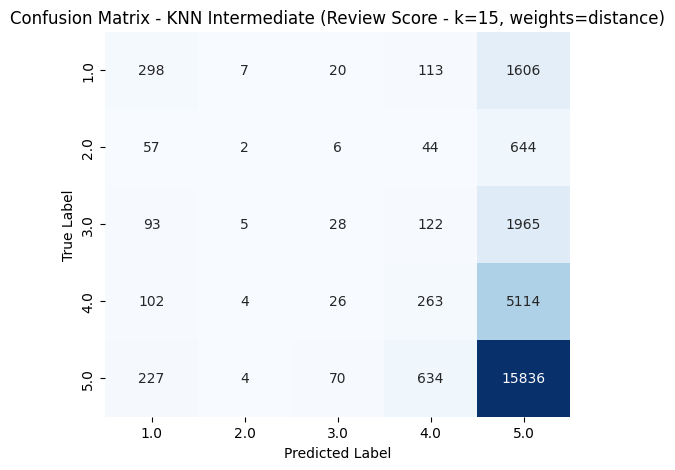

In [103]:
from sklearn.neighbors import KNeighborsClassifier

knn_intermediate_review = KNeighborsClassifier(n_neighbors=15, weights='distance')

knn_intermediate_review.fit(X_review_train, Y_review_train)

Y_pred_intermediate_review_knn = knn_intermediate_review.predict(X_review_test)

Y_pred_proba_intermediate_review_knn = knn_intermediate_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_knn,
    model_name='KNN Intermediate (Review Score - k=15, weights=distance)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_intermediate_review_knn,
    model_name='KNN Intermediate (Review Score - k=15, weights=distance)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_intermediate_review_knn))))
)

Al variar los parámetros, obtuvimos rendimiento similar. Esto nos indica que el modelo no se ha logrado adecuar a los datos y debemos explorar un espacio parametral más amplio.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}

--- Metrics for KNN Grid Search Best (Review Score - F1-macro) ---
Accuracy: 0.5245511176255039
Precision: 0.4632176554527314
Recall: 0.5245511176255039
F1-Score: 0.4880962951854406

Classification Report:
              precision    recall  f1-score   support

         1.0       0.24      0.18      0.21      2044
         2.0       0.05      0.01      0.02       753
         3.0       0.10      0.05      0.07      2213
         4.0       0.22      0.16      0.19      5509
         5.0       0.64      0.77      0.70     16771

    accuracy                           0.52     27290
   macro avg       0.25      0.24      0.24     27290
weighted avg       0.46      0.52      0.49     27290

------------------------------------------------------------------


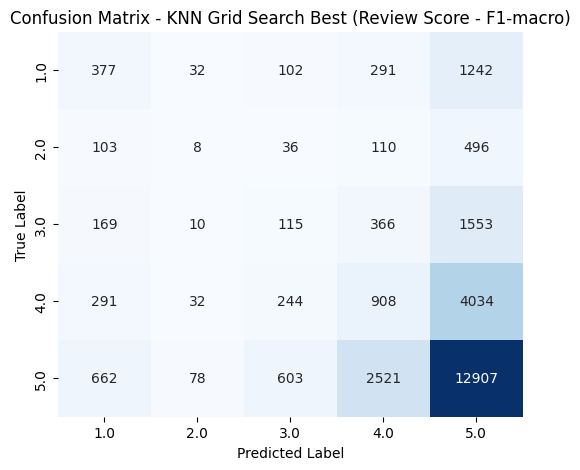

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_review = KNeighborsClassifier()

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_knn_review = GridSearchCV(
    knn_review,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_knn_review.fit(X_review_train, Y_review_train)

best_params_knn_review = grid_search_knn_review.best_params_
best_knn_model_review = grid_search_knn_review.best_estimator_

print("Best parameters found by Grid Search:", best_params_knn_review)

Y_pred_best_knn_review = best_knn_model_review.predict(X_review_test)
Y_pred_proba_best_knn_review = best_knn_model_review.predict_proba(X_review_test)

print_classification_metrics(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_knn_review,
    model_name='KNN Grid Search Best (Review Score - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_review_test,
    Y_pred=Y_pred_best_knn_review,
    model_name='KNN Grid Search Best (Review Score - F1-macro)',
    classes=sorted(list(set(Y_review_test).union(set(Y_pred_best_knn_review))))
)


En comparación a los modelos anteriores, obtuvimos mejoras. Sin embargo, el rendimiento del modelo optimizado para KNN fue muy pobre. Las predicciones siguen siendo variadas, pero no se logra encontrar ningún tipo de precisión.

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for KNN Baseline (Satisfaction - k=5) ---
Accuracy: 0.7992304873580066
Precision: 0.7483315345059592
Recall: 0.7992304873580066
F1-Score: 0.7613393300747394

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.15      0.21      5010
           1       0.83      0.95      0.88     22280

    accuracy                           0.80     27290
   macro avg       0.61      0.55      0.55     27290
weighted avg       0.75      0.80      0.76     27290

-----------------------------------------------------


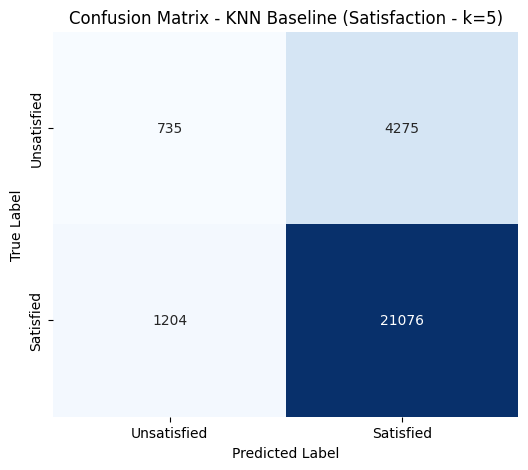

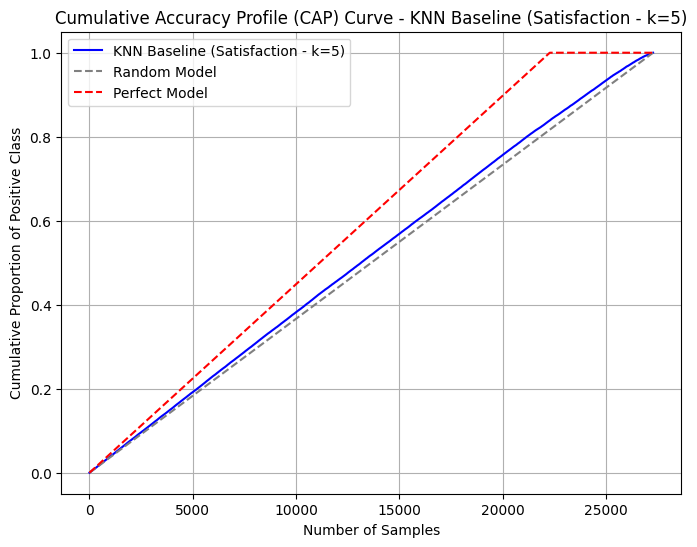

In [105]:
from sklearn.neighbors import KNeighborsClassifier

knn_baseline_satisfaction = KNeighborsClassifier(n_neighbors=5)

knn_baseline_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_baseline_satisfaction_knn = knn_baseline_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_baseline_satisfaction_knn = knn_baseline_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_knn,
    model_name='KNN Baseline (Satisfaction - k=5)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_baseline_satisfaction_knn,
    model_name='KNN Baseline (Satisfaction - k=5)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_baseline_satisfaction_knn,
    model_name='KNN Baseline (Satisfaction - k=5)'
)

El modelo Baseline de KNN es similar al de NB, dónde el modelo no sufre de centrarse en las predicciones más altamente representadas dentro del set de datos. Sin embargo, observando la curva CAP nos podemos dar cuenta que el rendimiento es similar a un modelo aleatorio.

**Modelo con Parametros Modificados**


--- Metrics for KNN Intermediate (Satisfaction - k=15, weights=distance) ---
Accuracy: 0.8181751557347013
Precision: 0.7735450611194107
Recall: 0.8181751557347013
F1-Score: 0.7659556715679205

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.11      0.18      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.68      0.54      0.54     27290
weighted avg       0.77      0.82      0.77     27290

----------------------------------------------------------------------------


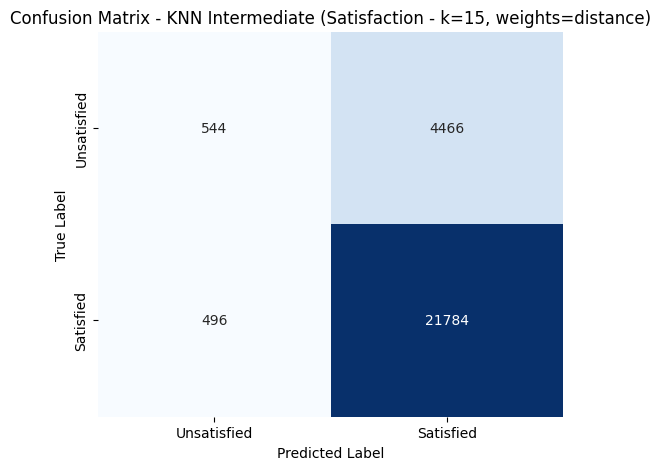

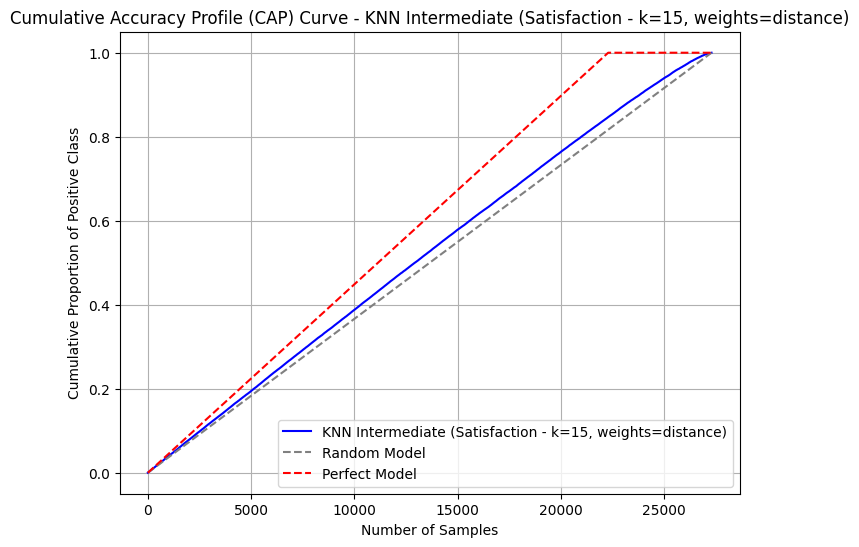

In [106]:
from sklearn.neighbors import KNeighborsClassifier

knn_intermediate_satisfaction = KNeighborsClassifier(n_neighbors=15, weights='distance')

knn_intermediate_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

Y_pred_intermediate_satisfaction_knn = knn_intermediate_satisfaction.predict(X_satisfaction_test)

Y_pred_proba_intermediate_satisfaction_knn = knn_intermediate_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_intermediate_satisfaction_knn,
    model_name='KNN Intermediate (Satisfaction - k=15, weights=distance)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_intermediate_satisfaction_knn,
    model_name='KNN Intermediate (Satisfaction - k=15, weights=distance)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_intermediate_satisfaction_knn,
    model_name='KNN Intermediate (Satisfaction - k=15, weights=distance)'
)


Variando los parámetros, observamos una mejora en cuánto a la curva CAP y las métricas ponen a este modelo con un rendimiento similar a los demás.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

--- Metrics for KNN Grid Search Best (Satisfaction - F1-macro) ---
Accuracy: 0.7966288017588861
Precision: 0.7473766139270532
Recall: 0.7966288017588861
F1-Score: 0.7611351926526237

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.16      0.22      5010
           1       0.83      0.94      0.88     22280

    accuracy                           0.80     27290
   macro avg       0.60      0.55      0.55     27290
weighted avg       0.75      0.80      0.76     27290

------------------------------------------------------------------


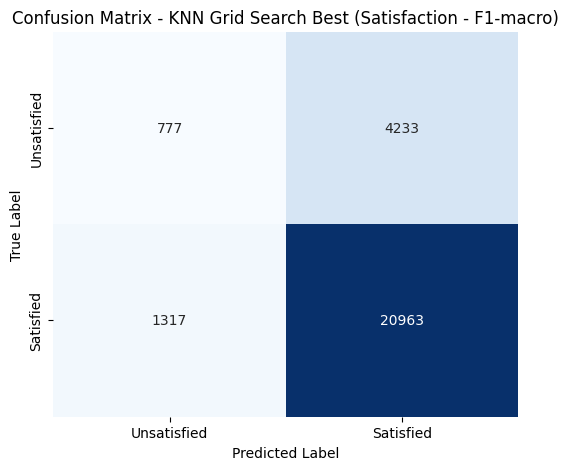

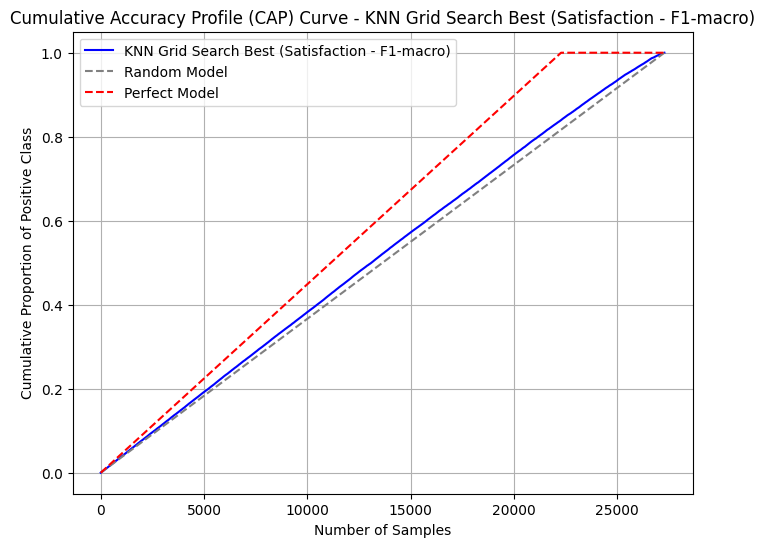

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_satisfaction = KNeighborsClassifier()

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_knn_satisfaction = GridSearchCV(
    knn_satisfaction,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_knn_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

best_params_knn_satisfaction = grid_search_knn_satisfaction.best_params_
best_knn_model_satisfaction = grid_search_knn_satisfaction.best_estimator_

print("Best parameters found by Grid Search:", best_params_knn_satisfaction)

Y_pred_best_knn_satisfaction = best_knn_model_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_knn_satisfaction = best_knn_model_satisfaction.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_knn_satisfaction,
    model_name='KNN Grid Search Best (Satisfaction - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_knn_satisfaction,
    model_name='KNN Grid Search Best (Satisfaction - F1-macro)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_knn_satisfaction,
    model_name='KNN Grid Search Best (Satisfaction - F1-macro)'
)

Al realizar un Gridsearch con validación cruzada observamos una ligera mejora en el modelo, sin embargo la curva CAP nos sigue indicando que en general el modelo es bastante pobre. Por lo cuál podemos afirmar que el modelo no se adaptó al conjunto de datos o no exploramos un espacio parametral lo suficientemente amplio.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for KNN Baseline (Delivery Delayed - k=5) ---
Accuracy: 0.9618908024917552
Precision: 0.9370340925064059
Recall: 0.9618908024917552
F1-Score: 0.945756973787655

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.23      0.02      0.03      1001

    accuracy                           0.96     27290
   macro avg       0.60      0.51      0.51     27290
weighted avg       0.94      0.96      0.95     27290

---------------------------------------------------------


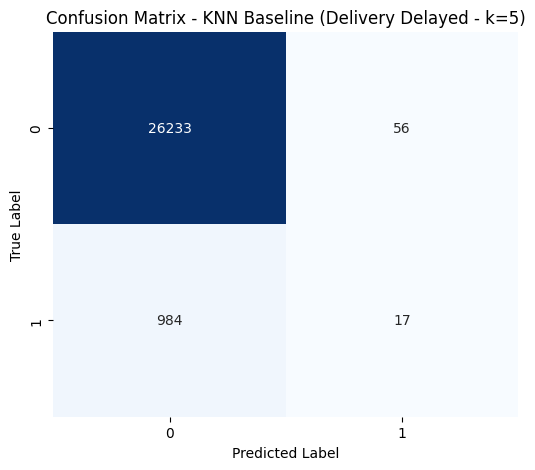

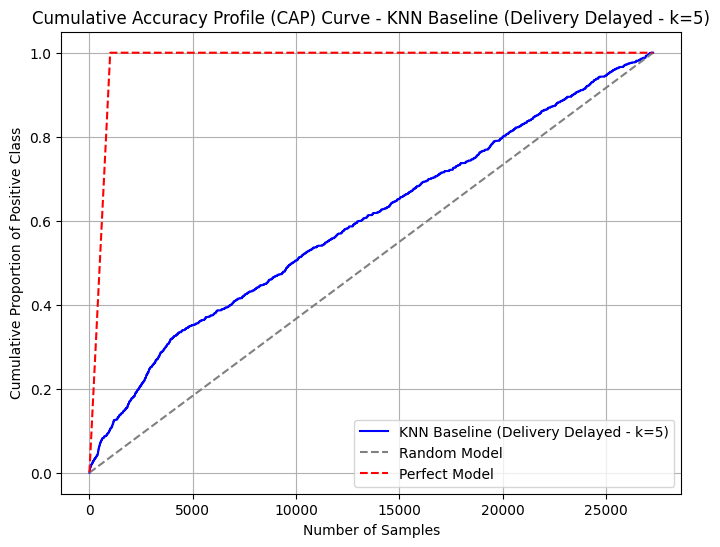

In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn_baseline_delayed = KNeighborsClassifier(n_neighbors=5)

knn_baseline_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_baseline_delayed_knn = knn_baseline_delayed.predict(X_delayed_test)

Y_pred_proba_baseline_delayed_knn = knn_baseline_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_knn,
    model_name='KNN Baseline (Delivery Delayed - k=5)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_baseline_delayed_knn,
    model_name='KNN Baseline (Delivery Delayed - k=5)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_baseline_delayed_knn))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_baseline_delayed_knn,
    model_name='KNN Baseline (Delivery Delayed - k=5)'
)

El modelo baseline de KNN tuvo un rendimiento bastante bueno en comparación a los demás, en los modelos anteriores este normalmente tenía un rendimiento similar al aleatorio. Al variar los parámetros esperamos encontrar resultados positivos.

**Modelo con Parametros Modificados**


--- Metrics for KNN Intermediate (Delivery Delayed - k=15, weights=distance) ---
Accuracy: 0.9630633931843166
Precision: 0.9418887974237332
Recall: 0.9630633931843166
F1-Score: 0.9459011148638222

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.37      0.01      0.02      1001

    accuracy                           0.96     27290
   macro avg       0.67      0.50      0.50     27290
weighted avg       0.94      0.96      0.95     27290

--------------------------------------------------------------------------------


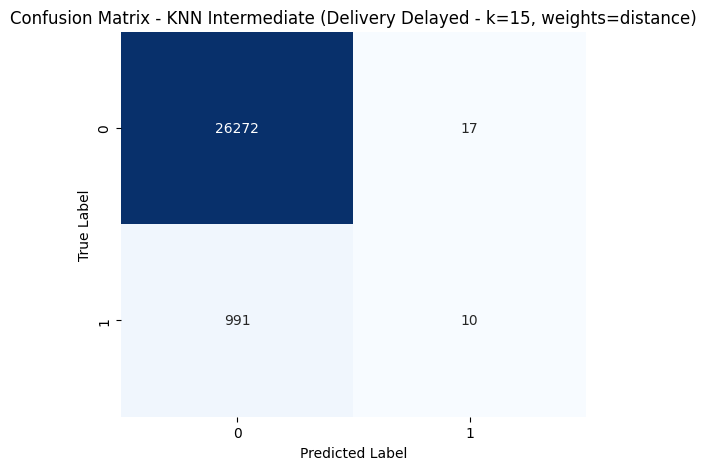

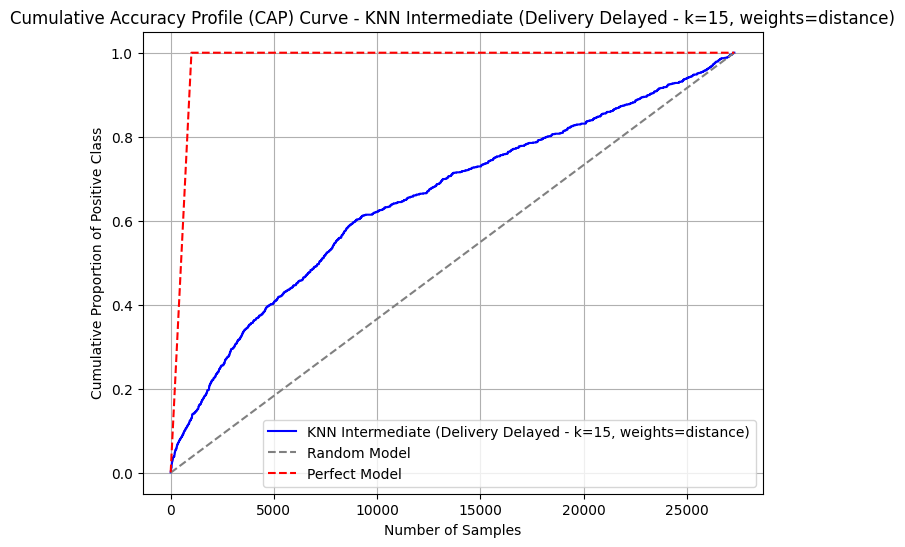

In [109]:
from sklearn.neighbors import KNeighborsClassifier

knn_intermediate_delayed = KNeighborsClassifier(n_neighbors=15, weights='distance')

knn_intermediate_delayed.fit(X_delayed_train, Y_delayed_train)

Y_pred_intermediate_delayed_knn = knn_intermediate_delayed.predict(X_delayed_test)

Y_pred_proba_intermediate_delayed_knn = knn_intermediate_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_intermediate_delayed_knn,
    model_name='KNN Intermediate (Delivery Delayed - k=15, weights=distance)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_intermediate_delayed_knn,
    model_name='KNN Intermediate (Delivery Delayed - k=15, weights=distance)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_intermediate_delayed_knn))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_intermediate_delayed_knn,
    model_name='KNN Intermediate (Delivery Delayed - k=15, weights=distance)'
)


En este modelo empezamos a ver cómo existe una mayor tendencia a apuntar hacia deliveries a tiempo, esto da una mejor precisión del modelo pero sigue sin tener mucho recall para los valores de deliveries atrasados.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

--- Metrics for KNN Grid Search Best (Delivery Delayed - F1-macro) ---
Accuracy: 0.955734701355808
Precision: 0.9357890477828669
Recall: 0.955734701355808
F1-Score: 0.9444825210315804

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     26289
           1       0.17      0.05      0.08      1001

    accuracy                           0.96     27290
   macro avg       0.57      0.52      0.53     27290
weighted avg       0.94      0.96      0.94     27290

----------------------------------------------------------------------


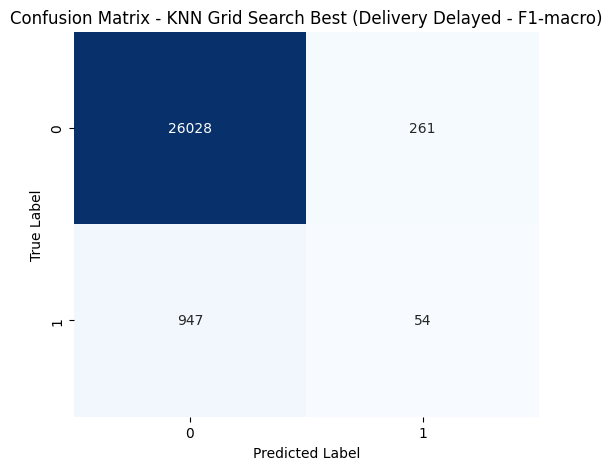

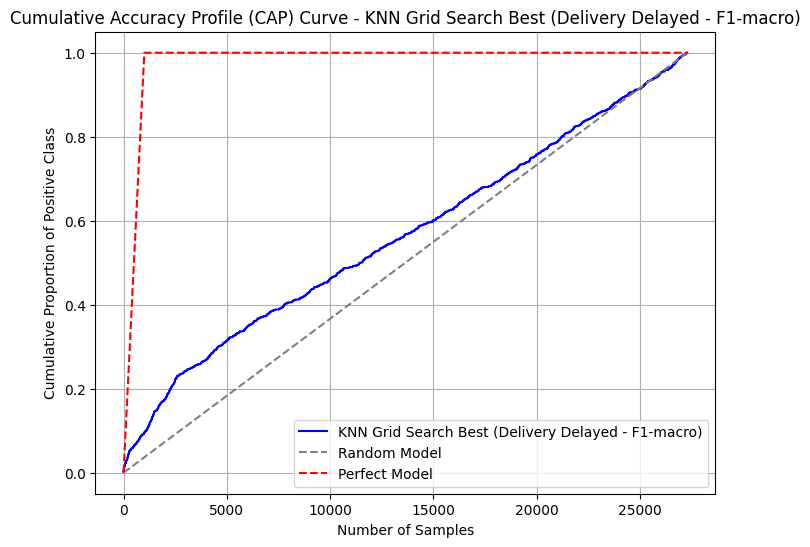

In [110]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_delayed = KNeighborsClassifier()

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

grid_search_knn_delayed = GridSearchCV(
    knn_delayed,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

grid_search_knn_delayed.fit(X_delayed_train, Y_delayed_train)

best_params_knn_delayed = grid_search_knn_delayed.best_params_
best_knn_model_delayed = grid_search_knn_delayed.best_estimator_

print("Best parameters found by Grid Search:", best_params_knn_delayed)

Y_pred_best_knn_delayed = best_knn_model_delayed.predict(X_delayed_test)
Y_pred_proba_best_knn_delayed = best_knn_model_delayed.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_knn_delayed,
    model_name='KNN Grid Search Best (Delivery Delayed - F1-macro)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_knn_delayed,
    model_name='KNN Grid Search Best (Delivery Delayed - F1-macro)',
    classes=sorted(list(set(Y_delayed_test).union(set(Y_pred_best_knn_delayed))))
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_knn_delayed,
    model_name='KNN Grid Search Best (Delivery Delayed - F1-macro)'
)

Este modelo empieza prometedor, sin embargo al final empieza a tener un rendimiento similar al de un modelo aleatorio. Esto nos indica que el modelo no logró captar la información proveída por los datos.

**Análisis Comparativo**

El aplicar validación cruzada no resultó en lo esperado, ya que no se logró obtener un modelo adecuado. Sin embargo, en este caso en específico podríamos argumentar que la métrica con la que se evalúa el modelo puede afectar la validación cruzada. Ya que algunas métricas aumentaron a pesar de que la curva CAP no vió mejora alguna.

## Conclusiones

- En algunos modelos como Random Forest, consideramos que es crucial realizar un proceso de validación cruzada para explorar espacios parametrales amplios
- Es de suma importancia utilizar las métricas correctas para obtener buenos resultados al aplicar validación cruzada.
- En general, Random Forest fue el mejor predictor para cada una de nuestras variables categóricas.
- La distribución de las variables objetivo tienen un efecto muy marcado sobre los modelos.
- NB es una alternativa completamente viable con bajo costo computacional.